# Fitting a scaled LDA model via proximal gradient descent
_Date:_ October 10, 2024

Our overarching goal remains to identify a robust strategy for recovering the true data-generating parameters through these synthetic simulations, so that we can have greater confidence in the inferred parameters when applied to experimental datasets.

**Background.**
In `2024-10-07-Scaled-LDA-EM-PGD.ipynb`, we attempted to fit a model with a larger vocabulary size ($V=30$) and larger number of topics ($K=6$) but had negative results.
We had performed cross-validation over 3 folds and 5 initializations and chose to fit an $\hat{K}=8$ model.
However, we observed that
- the algorithm appeared to converge slowly (not fully converged after 200 iterations, althugh training for more iterations is no longer a significant computational barrier),
- the inferred topics were qualitiatively very similar to their initializations,
- the inferred scales did not change from their initialization based on median empirical usage
- the inferred weights exhibited the greatest change, in which they _visually appeared_ to be moving towards $1/K$ (take this observation with a grain of salt).

**This notebook.**
Following-up on these observations, we will
1. Write a function to generate a collection of "well-seperated" topics. Use this to generate the topics in the data-enerating process, as well as for topic parameter initialization. This is inspired by data-generating approach described in Bystrov et al. to evaluate a collection of topics and generate topics.
2. Re-examine the $\alpha_\sigma \rightarrow \infty$, aka standard LDA case. Sanity check that we did not break our algorithm in some way, and revisit some "best practices" for recovery the true topics.
3. If sanity check for standard LDA passes, evaluate model performance as a function of $\alpha_\sigma$ value, for a given topic and weights set.
4. Try initializing weights with uniform $1/K$. Does this help or hurt model fit?

Other thoughts to keep in the back of our minds, but that will not be pursued explicitly here:
1. Does the singular Bayesian information criterion (sBIC) (see: Drton and Plummer; Bystrov et al.) capture the "shoulder" rule-of-thumb for choosing the number of topics in an LDA model?
2. Is the rule-of-thumb of fitting LDA models with $\tilde{K} > K$ actually just a symptom of effects of bad topic initializations? Then, by fitting a larger number of topics, one has a better chance of finding the true topics because one simply has more initializations to work with.
3. Can we speed-up EM by introducing some notion of momentum? This idea was explored for HMMs in Miller et al., who use the difference between parameters before and after an update as a "discrete gradient" and apply a scaling hyperparameter.
    - The `sklearn` implementation has a parameter `max_doc_topic_iters` which specifies the maximum number of document-topic (weights) update iterations per E-step. I believe this parameter is only relevant to their algorithm (based off of Hoffman et al.), but I would need to look more clearly to understand it.
4. Is it possible that the scaled LDA model is not identifiable? We have not considered how the scale parameter interacts with the vocabulary usage across topics (e.g. visualization `topics.sum(axis=0)` -- it's not uniform! This was potentially not a problem in standard LDA because the "global" usages were uniform, but if "global" _and_ "local"/topic-wise usages are non-uniform, how to seperate from where each non-uniformity?)

**Results and conclusions**
...

**References**
1. Bystrov, Naboka-Krell, Staszewska-Bystrova, and Winker. "Choosing the number of topics in LDA models - A Monte Carlo comparison of selection criteria." (JMLR, 2024). [[link]](https://www.jmlr.org/papers/volume25/23-0188/23-0188.pdf).
2. Drton and Plummer. "A Bayesian information criterion for singular models." (JRSS, 2017). [[link]](https://arxiv.org/abs/1309.0911)
3. Miller, Di Troia, and Stamp. "Hidden Markov Models with Momentum." (preprint, 2022). [[link]](https://arxiv.org/abs/2206.04057)
4. Hoffman, Blei, Wang, and Paisley. "Stochastic variational inference.' (JMLR, 2013). [[link]](https://jmlr.org/papers/volume14/hoffman13a/hoffman13a.pdf)


In [2]:
from collections import namedtuple
from typing import Callable, Optional, Sequence
from jax.typing import ArrayLike
from jax import Array
KeyArray = Array

from functools import partial
import pickle
from tqdm.auto import tqdm

import jax
from jax import jit, grad, lax, vmap
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp

import numpy as onp

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.optimize import linear_sum_assignment

from sklearn.decomposition import LatentDirichletAllocation as LDA

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
AutoIntLocator = mpl.ticker.MaxNLocator(nbins='auto', steps=[1,2,5,10], integer=True)

/scratch/users/eyz/miniconda3/envs/dtd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generating seperated topics from a Dirichlet distribution

In order for an algorithm to fit a LDA model stably, the topics must be well-seperated (mentioned in Bystrov et al. and makes sense in hindsight).
When we generate synethetic topics for such a model, we need to ensure that the topics are indeed well-seperated.
Another assumption about the topics, at least for our final downstream applications, is that the topics are sparsely distributed over the vocabulary.

Sampling a small number of topics independently from a Dirichlet distribution, however, doesn't necessarily guarantee that the samples are well-seperated.
Let's examine how different a finite set of IID draws from a Dirichlet distribution are, as a function a concentration and dimension.

In [3]:
# Examine the distribution of pairwise similar topics as a function of vocab size and concentration
n_samples = 100
concs = jnp.array([0.1, 0.5, 0.9, 1.0, 2, 10])
dims = jnp.array([5, 10, 30])

key = jr.key(0)
all_samples = []  # len (n_dims), elements are arrays of shape (n_concs, n_samples, dim)
for dim in dims:
    all_samples.append(
        vmap(
            lambda conc: jr.dirichlet(key, conc*jnp.ones(dim), shape=(n_samples,))
        )(concs)
    )

2024-10-11 21:02:43.426224: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


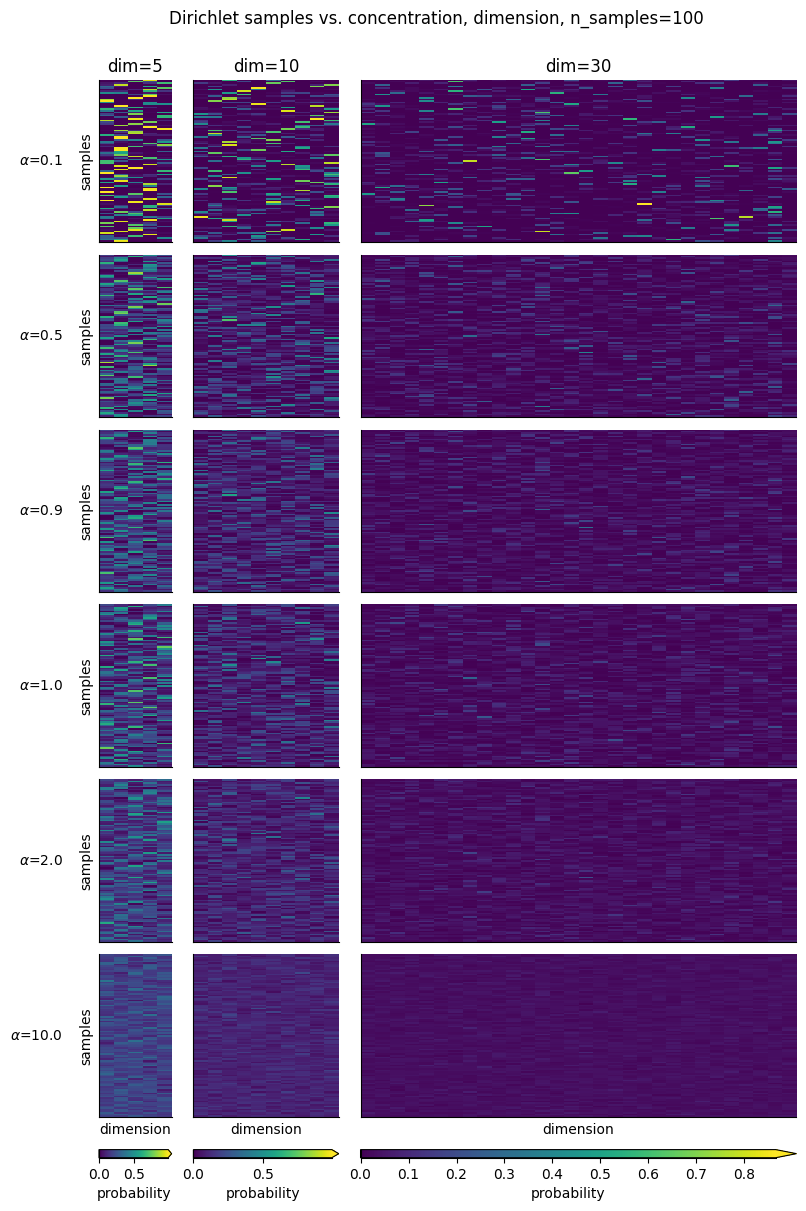

In [4]:
n_concs = len(concs)
n_dims = len(dims)

fig, axs = plt.subplots(
    nrows=n_concs+2, height_ratios=[1]*n_concs + [0.05, 0.05],
    ncols=n_dims, width_ratios=dims,
    gridspec_kw={'hspace': 0.1, 'wspace': 0.1},
    figsize=(9, 14)
)

for ax in axs[-2,:]:  # second to last row is just buffer zone
    ax.remove() 

axs, caxs = axs[:-2,:], axs[-1,:]  # split into main axes and colorbar axes

for i_col, dim in enumerate(dims):
    for i_row, conc in enumerate(concs):
        vmax = all_samples[i_col].max()

        ax = axs[i_row, i_col]
        im = ax.imshow(
            all_samples[i_col][i_row], vmin=0, vmax=vmax, aspect='auto', interpolation='none'
        )
        ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

    # add colorbar for the concentration
    plt.colorbar(im, cax=caxs[i_col], extend='max' if vmax < 1 else 'none', orientation='horizontal', label='probability')

for ax, conc in zip(axs[:,0], concs):  # first column: label y-axis, add concentration labels
    ax.set_ylabel('samples')
    ax.text(-0.5, 0.5, r'$\alpha$='+f'{conc:0.1f}', transform=ax.transAxes,
            ha='right', va='center', fontsize='medium')

for ax, dim in zip(axs[0,:], dims):  # first row: add dim labels
    ax.set_title(f'dim={dim:d}')

for ax in axs[-1,:]:  # bottom row: label x-axis
    ax.set_xlabel('dimension')

fig.suptitle(
    f'Dirichlet samples vs. concentration, dimension, {n_samples=}', y=0.93,
)

sns.despine()

Consistent with our understanding of the concentration parmeter, decreasing concentration $\alpha>0$ increases sparsity, particularly when $\alpha < 1$.
We also note that sparsity become more apparent, at least visually, with great dimensionality.


## Distance metrics between Dirichlet distributed samples
**Cosine distance**

A common metric for measuring topic similarity, or correlation, is the cosine distance (Cao et al., 2009),
\begin{equation}
D_\textrm{cosine}(\mathbf{p},\mathbf{q}) = 1 - \frac{\mathbf{p}\cdot\mathbf{q}}{\Vert \mathbf{p} \Vert_2 \Vert \mathbf{q} \Vert_2 }.
\end{equation}
where $\mathbf{p} \in \mathbb{R}^d, \mathbf{q} \in \mathbb{R}^d$ are two $d$-dimensional vectors. In our case of interest, they are specifically two vectors on the simplex $\mathbf{p} \in \Delta_d, \mathbf{q} \in \Delta_d$.

Let's evaluate the pairwise distances between each set of samples by this metric.

In [5]:
def cosine_dist(u, v):
    """Compute cosine distance between two vectors of same length."""

    return 1 - jnp.dot(u, v) / jnp.sqrt(jnp.sum(u**2)) / jnp.sqrt(jnp.sum(v**2))

def pdist_jax(arr, fn, return_mat: bool=False):
    """Pairwise distances between observations. JAX implementations of `scipy.spatial.distances.pdist`

    Parameters
        arr: shape (N,D). Array of N observations in a D-dimensional space.
        fn: Callable. Distance function taking in two vectors of same length.
        return_mat: bool. If True, return a dense (N,N) distance matrix.
            Default: False, return the distance matrix as a condensed vector,
            of the upper triangular elements, length (N*(N-1)/2).
    
    Returns
        dists: shape (N,N) if return_mat else (N * (N-1)/2,).

    """

    mat = vmap(vmap(fn, in_axes=(0,None)), in_axes=(None,0))(arr, arr)

    if return_mat:
        return mat
    else:
        i, j = jnp.triu_indices_from(mat, 1)
        return mat.at[i,j].get()

In [6]:
metric = cosine_dist
metric_name = 'cosine'

n_examples = 15

# Choose examples along the distribution so we can see what different distances look like
example_ij_idxs = onp.concatenate([
    [0,], onp.geomspace(10, n_samples*(n_samples-1)//2-1, num=n_examples-1, dtype=int)
])

all_sorted_dists, all_sorted_sample_ids, all_example_ids = [], [], []
for i_dim in range(n_dims):
    these_sorted_dists, these_example_ids = [], []
    for i_conc in range(n_concs):
        samples = all_samples[i_dim][i_conc]
        
        # Compute all pairwise distances; shape: (n_choose_2_samples,)
        dists = pdist_jax(samples, metric)

        # Sort distances so we can see the distribution curve
        sorted_dist_idxs = onp.argsort(dists, axis=-1)
        sorted_dists = dists[sorted_dist_idxs]
        these_sorted_dists.append(sorted_dists)

        # Sort samples by pairwise distance
        ijs = onp.stack(onp.triu_indices(n_samples, 1), axis=-1)  # shape (n_choose_2_samples, 2)
        sorted_ijs = ijs[sorted_dist_idxs]
        these_example_ids.append(sorted_ijs[example_ij_idxs])
    
    all_sorted_dists.append(onp.array(these_sorted_dists))
    all_example_ids.append(onp.array(these_example_ids))
    

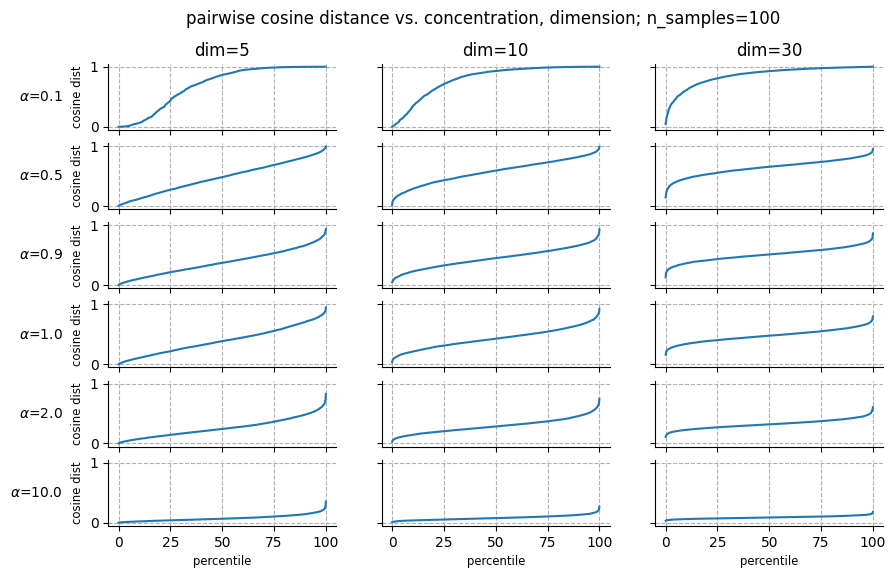

In [7]:
n_xticks = 5

fig, axs = plt.subplots(
    nrows=n_concs, ncols=n_dims, sharex=True, sharey=True, figsize=(10,6),
)

n_pairs = (n_samples * (n_samples - 1)) // 2
xtick_labels = [f'{x:d}' for x in onp.linspace(0, 100, num=n_xticks, dtype=int)]

for i_col, dim in enumerate(dims):
    for i_row, conc in enumerate(concs):
        ax = axs[i_row, i_col]
        ax.plot(all_sorted_dists[i_col][i_row])
        ax.set_xticks(onp.linspace(0, n_pairs-1, num=n_xticks))
        ax.tick_params(labelbottom=False)
        ax.grid(ls='--')

for ax, conc in zip(axs[:,0], concs):  # first column: label y-axis, add concentration labels
    ax.set_ylabel(f"{metric_name} dist", fontsize='small')
    ax.text(-0.2, 0.5, r'$\alpha$='+f'{conc:0.1f}', transform=ax.transAxes,
            ha='right', va='center', fontsize='medium')

for ax, dim in zip(axs[0,:], dims):  # first row: add dim labels
    ax.set_title(f'dim={dim:d}')

for ax in axs[-1,:]:  # bottom row: label x-axis
    ax.set_xticklabels(xtick_labels)
    ax.tick_params(labelbottom=True)
    ax.set_xlabel('percentile', fontsize='small')

fig.suptitle(
    f'pairwise {metric_name} distance vs. concentration, dimension; {n_samples=}', y=0.97,
)

sns.despine()

For $\alpha=0.1$, let's examine what this distances look like.

Text(0.5, 0.96, 'Examples of sample pairs, via cosine distance, for $\\alpha$=0.1')

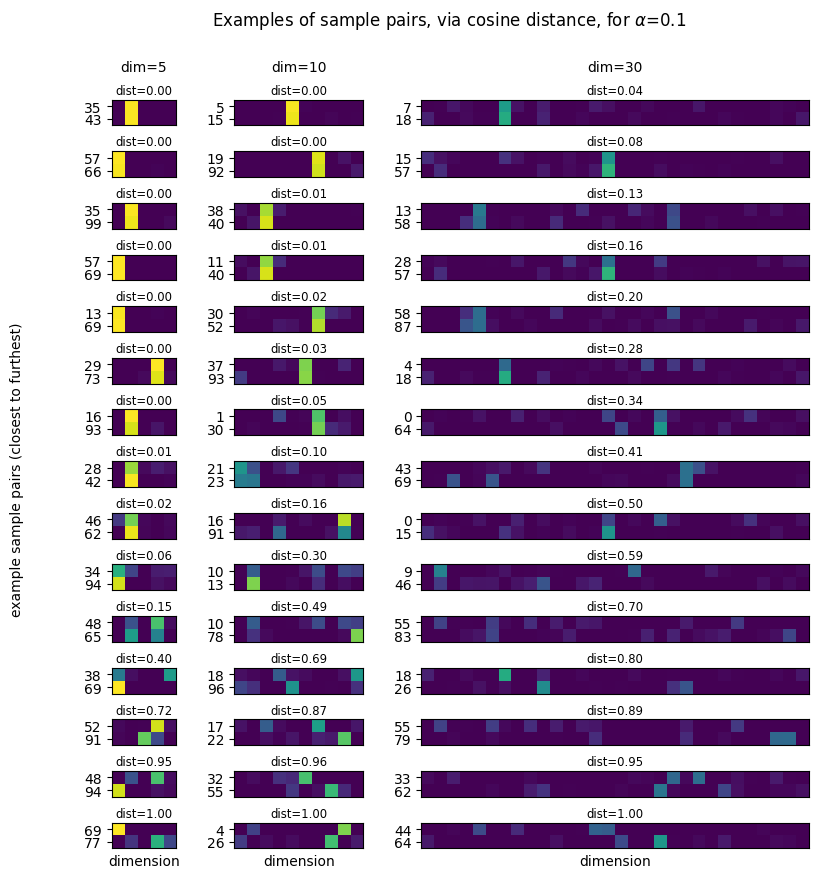

In [8]:
n_dims = len(dims)

fig, axs = plt.subplots(
    nrows=n_examples,
    ncols=n_dims, width_ratios=dims,
    gridspec_kw={'hspace': 0.1, 'wspace': 0.3},
    figsize=(9, 10)
)

i_conc = 0
conc = concs[i_conc]
for i_col, dim in enumerate(dims):
    for i_row in range(n_examples):
        ax = axs[i_row, i_col]

        ids = all_example_ids[i_col][i_conc][i_row]
        samples = all_samples[i_col][i_conc][ids]
        
        im = ax.imshow(samples, vmin=0, vmax=1)

        ax.tick_params(bottom=False, labelbottom=False)

        ax.set_yticks([0,1])
        ax.set_yticklabels(ids)

        dist = metric(samples[0], samples[1])
        ax.set_title(f"dist={dist:.2f}", fontsize='small', y=0.90)

# label rows
plt.text(0.02, 0.5, 'example sample pairs (closest to furthest)', transform=fig.transFigure,
         ha='center', va='center', rotation=90, fontsize='medium')


for ax, dim in zip(axs[0,:], dims):  # first row: add dim labels
    # ax.set_title(f'dim={dim:d}')
    ax.text(0.5, 2.0, f'dim={dim:d}', transform=ax.transAxes,
            ha='center', va='bottom', fontsize='medium')

for ax in axs[-1,:]:  # bottom row: label x-axis
    ax.set_xlabel('dimension')

fig.suptitle(f"Examples of sample pairs, via {metric_name} distance, for "+r"$\alpha$"+f"={conc:.1f}", y=0.96)

The example pairs are selected along the logarithmically along the percentile distribution. Pairs that have a closer distane are indeed more similar to one another. Qualitatively, a good threshold for minimum pairwise distance would be $D_\textrm{cosine} \geq 0.60$.

**Hellinger distance.**

The Hellinger distance, otherwise known as the Jeffrys or Jefferys-Matusita distance, is a divergence between two probabilistic distributions.
Rauber, Braun, and Berns worked out the definition of such a distance for the Dirichlet distirbution (see: _"Probabilistic distance measures of the Dirichlet and Beta distributions." (2008) [[link]](https://www.sciencedirect.com/science/article/pii/S0031320307003123)_) by deriving the Chernoff probabilsitic distance between two Dirichlet distributions, from which the Bhattacharyya distance follows, from which the Hellinger distance can be defined.

The Hellinger distance can be defined as $D_H = \sqrt{1-C_B}$, where $C_B=$ is the Bhattacharyya coefficient.
The Bhattacharyya coefficient between two Dirichlet distributions, described by their parameters $\mathbf{\alpha}_1 \in \mathbb{R}_+^d$ and $\mathbf{\alpha}_2\in \mathbb{R}_+^d$, respectively, is given by (Eqn. 17 in original text):
\begin{equation}
C_B(\mathbf{\alpha}_1, \mathbf{\alpha}_2) = \frac{B\left(\frac{\mathbf{\alpha}_1 + \mathbf{\alpha}_2}{2}\right)}{\sqrt{B(\mathbf{\alpha}_1) B(\mathbf{\alpha}_2)}},
\end{equation}
where $B(\cdot)$ is the multivariate beta function defined as
\begin{equation*}
B(\mathbf{\alpha}) = \frac{\prod_{i=1}^d \large\Gamma(\alpha_i)}{\large\Gamma\left(\textstyle{\sum_{i=1}^d}\alpha_i\right)}
\end{equation*}
and $\Gamma(\cdot)$ denotes the gamma function.

Since $\Gamma(x) \rightarrow \infty$ as $x \rightarrow 0$, we can compute $C_B$ with more numerical stability by working in the log space.
Equation 16 of the reference text presents the Chernoff distance between two Dirichlet distributions, which gives the negative log of Bhattacharyya coefficeint (also referred to as the Bhattacharyya distance).

Typically, this distance is used after inferring the parameters $\mathbf{\alpha}_1$ and $\mathbf{\alpha}_2$ from two different sample sets to determine if they arose from the same distribution. We co-opt this distance measure for just two independent samples; such a co-opt-ing seems to also be used for e.g. the KL divergence. I don't recall the exact argument justifying the use of this.

In [9]:
def hellinger_dist(p, q):
    """Calculate the Hellinger distance. Also known as the Jeffreys-Matusita distance.

    This metric is a proper distance metric, i.e. it satisfies the triangle inequality,
    and is bounded between 0 (p and q overlap) and 1 (p and q are seperated).

    Assumes that p, q are simplex vectors, i.e. non-negative and sum to 1.
    This metric is calculated via the Bhattacharrya coefficient, C_B(p,q),
        D_H = \sqrt(1 - C_B(p,q)).
    For numerical stability, the Bhattacharrya coefficient is calculated
    in log space, as the Bhattacharrya distance, D_B, where
        C_B = exp(-D_B)
    
    See Eqn. 16 of Rauber, Brau, and Berns (2008).

    Parameters
        p: shape (d,)
        q: shape (d,)
            d-dimensional simplex vectors.

    Returns
        float, between 0 (close) and 1 (far)
    """

    # Calculate the Bhattacharyya distance for Dirichlet distributions (Eqn. 16)
    db = jsp.special.gammaln(0.5 * jnp.sum((p+q)))
    db += 0.5 * (jnp.sum(jsp.special.gammaln(p)) + jnp.sum(jsp.special.gammaln(q)))
    db -= jnp.sum(jsp.special.gammaln(0.5*(p+q)))
    db -= 0.5 * jsp.special.gammaln(jnp.sum(jnp.abs(p)))
    db -= 0.5 * jsp.special.gammaln(jnp.sum(jnp.abs(q)))

    return jnp.sqrt(1 - jnp.exp(-db))

In [10]:
metric = hellinger_dist
metric_name = 'Hellinger'

n_examples = 15

# Choose examples along the distribution so we can see what different distances look like
example_ij_idxs = onp.concatenate([
    [0,], onp.geomspace(10, n_samples*(n_samples-1)//2-1, num=n_examples-1, dtype=int)
])

all_sorted_dists, all_sorted_sample_ids, all_example_ids = [], [], []
for i_dim in range(n_dims):
    these_sorted_dists, these_example_ids = [], []
    for i_conc in range(n_concs):
        samples = all_samples[i_dim][i_conc]
        
        # Compute all pairwise distances; shape: (n_choose_2_samples,)
        dists = pdist_jax(samples, metric)

        # Sort distances so we can see the distribution curve
        sorted_dist_idxs = onp.argsort(dists, axis=-1)
        sorted_dists = dists[sorted_dist_idxs]
        these_sorted_dists.append(sorted_dists)

        # Sort samples by pairwise distance
        ijs = onp.stack(onp.triu_indices(n_samples, 1), axis=-1)  # shape (n_choose_2_samples, 2)
        sorted_ijs = ijs[sorted_dist_idxs]
        these_example_ids.append(sorted_ijs[example_ij_idxs])
    
    all_sorted_dists.append(onp.array(these_sorted_dists))
    all_example_ids.append(onp.array(these_example_ids))

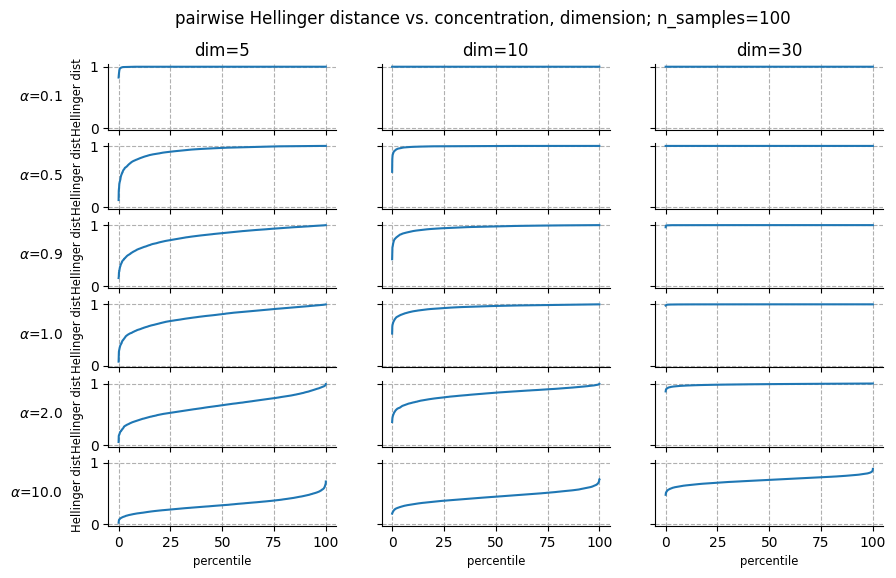

In [11]:
n_xticks = 5

fig, axs = plt.subplots(
    nrows=n_concs, ncols=n_dims, sharex=True, sharey=True, figsize=(10,6),
)

n_pairs = (n_samples * (n_samples - 1)) // 2
xtick_labels = [f'{x:d}' for x in onp.linspace(0, 100, num=n_xticks, dtype=int)]

for i_col, dim in enumerate(dims):
    for i_row, conc in enumerate(concs):
        ax = axs[i_row, i_col]
        ax.plot(all_sorted_dists[i_col][i_row])
        ax.set_xticks(onp.linspace(0, n_pairs-1, num=n_xticks))
        ax.tick_params(labelbottom=False)
        ax.grid(ls='--')

for ax, conc in zip(axs[:,0], concs):  # first column: label y-axis, add concentration labels
    ax.set_ylabel(f"{metric_name} dist", fontsize='small')
    ax.text(-0.2, 0.5, r'$\alpha$='+f'{conc:0.1f}', transform=ax.transAxes,
            ha='right', va='center', fontsize='medium')

for ax, dim in zip(axs[0,:], dims):  # first row: add dim labels
    ax.set_title(f'dim={dim:d}')

for ax in axs[-1,:]:  # bottom row: label x-axis
    ax.set_xticklabels(xtick_labels)
    ax.tick_params(labelbottom=True)
    ax.set_xlabel('percentile', fontsize='small')

fig.suptitle(
    f'pairwise {metric_name} distance vs. concentration, dimension; {n_samples=}', y=0.97,
)

sns.despine()

For $\alpha=0.1$, let's examine what this distances look like.

Text(0.5, 0.96, 'Examples of sample pairs, via Hellinger distance, for $\\alpha$=0.1')

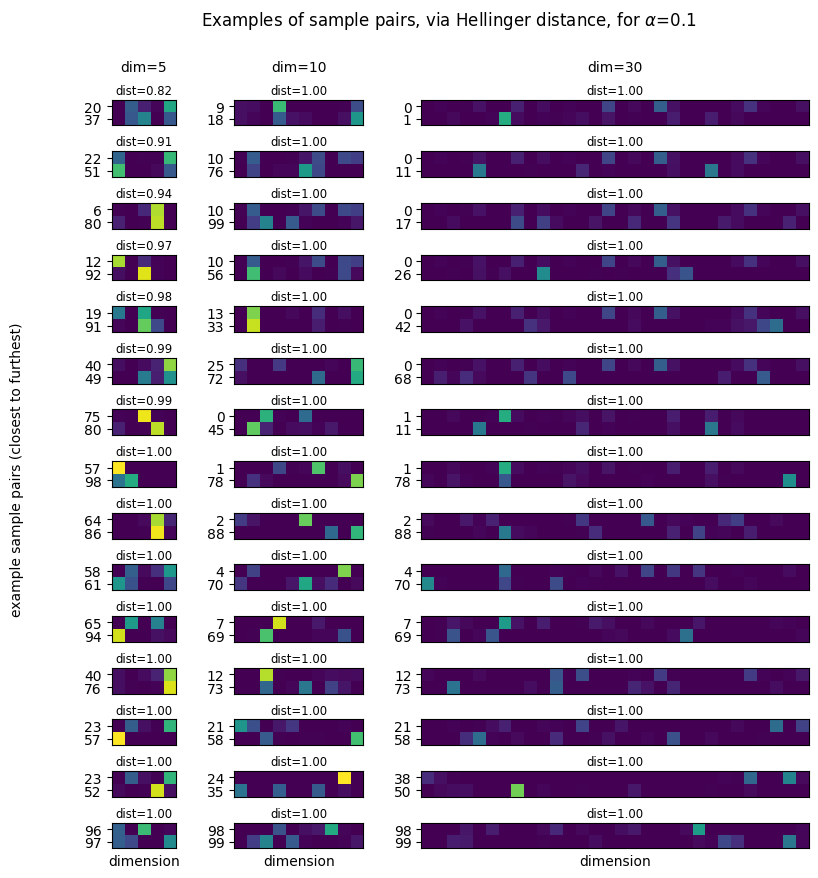

In [12]:
n_dims = len(dims)

fig, axs = plt.subplots(
    nrows=n_examples,
    ncols=n_dims, width_ratios=dims,
    gridspec_kw={'hspace': 0.1, 'wspace': 0.3},
    figsize=(9, 10)
)

i_conc = 0
conc = concs[i_conc]
for i_col, dim in enumerate(dims):
    for i_row in range(n_examples):
        ax = axs[i_row, i_col]

        ids = all_example_ids[i_col][i_conc][i_row]
        samples = all_samples[i_col][i_conc][ids]
        
        im = ax.imshow(samples, vmin=0, vmax=1)

        ax.tick_params(bottom=False, labelbottom=False)

        ax.set_yticks([0,1])
        ax.set_yticklabels(ids)

        dist = metric(samples[0], samples[1])
        ax.set_title(f"dist={dist:.2f}", fontsize='small', y=0.90)

# label rows
plt.text(0.02, 0.5, 'example sample pairs (closest to furthest)', transform=fig.transFigure,
         ha='center', va='center', rotation=90, fontsize='medium')


for ax, dim in zip(axs[0,:], dims):  # first row: add dim labels
    # ax.set_title(f'dim={dim:d}')
    ax.text(0.5, 2.0, f'dim={dim:d}', transform=ax.transAxes,
            ha='center', va='bottom', fontsize='medium')

for ax in axs[-1,:]:  # bottom row: label x-axis
    ax.set_xlabel('dimension')

fig.suptitle(f"Examples of sample pairs, via {metric_name} distance, for "+r"$\alpha$"+f"={conc:.1f}", y=0.96)

Looks like the Hellinger distance is quite liberal with what it deems far apart. This is particularly obvious in the first column, with $d=5$.
The third example between topics 6 and 80 are what I would call pretty similar, but the distance metric places that fairly far aprt.
While the last column, for $d=30$ looks fairly optimistic, recall that in the cosine distance analysis, there were clearly some topics that were close by cosine distance, but which were not visualized here. However, all the Hellinger distances from $d=30$ and $\alpha=0.1$ are 1 (see previous figure).

This is likely because I was attempting to co-opt the distance metric for distributions and apply ot samples of those distributions.
Numerically, the samples are constrained to be on the simplex, so $p+i < 1$ and the resulting gamma functions have very large values.
The parameters $\mathbf{\alpha}$ are actually pseudo-counts, and are typically $\alpha_i \gg 0$, therefore the resulting distance has more nuanced and accurate.

Anyhoo, for now we move forward with using the cosine distance as the metric for determining separated topics.

## Proposed procedure

Our approach is inspired by the data-generating process used by Bystrov et al. (2024). While they generate datasets by first inferring topics and weights from real document corpora (neat idea!), we simply generate synthetic topics and weights. We follow their approach in generating a superset of draws from a Dirichlet distribution, then evaluate their pairwise distances to choose a subset of topics that maximize distance.

Suppose we are interested in generating $N$ Dirichlet distributed topics. We define a minimum distance that all pairs of seleted topics must be from each other $c \in [0,1]$. Then,
1. Sample $X_i \overset{iid}{\sim} \textrm{Dir}(\alpha)$ for $i=1,\ldots,\tilde{N}$, where $\tilde{N} \gg N$.
2. Compute the pairwise distances $C(X_i,X_{i'})$ between all samples; this results in ${\tilde{N}\choose{2}} =\left(\tilde{N}(\tilde{N}-1)\right)/2$ distances.
3. Initialize the set of selected topics with the two topics with maximal pairwise distances, $Y^{(0)} = \{X_i, X_j\}$ where $(X_i, X_j) = \arg\max C(X_i,X_j)$. Track the selected topic indices, $\mathcal{J}=\{i,j\}$

    - Alternatively, we could seed the initial two topics probabilitistically, by choosing a sample pair with probability $\frac{C_k}{\sum_{k'\in \mathcal{K}C_{k'}}}$ where $\mathcal{K} = \{1, \ldots,  {\tilde{N}\choose 2}\}$.
4. While $|Y| < N$, iterate through the remaining unselected topics: 
If $C(i,j) \geq c$ for $i \in \mathcal{K}\backslash\mathcal{J}$ and for **all** $j \in \mathcal{J}$, then $Y \leftarrow Y \cup \{X_i\}$ and $\mathcal{J} \leftarrow \mathcal{J} \cup \{i\}$

5. Return $Y$.

Note that this algorithm is not guaranteed to be optimal in the sense of globally maximizing distances while all distances lie above some threshold.
It also does not guarantee that $N$ topics will be found. However, we use this algorithm because it is easy to implement. It may require some tuning of the threshold value.

**A more optimal solution (future work)**
A more optimal formulation is to find the $N$ subset of $\tilde{N}$ samples that respects the threshold conditions.
\begin{align*}
\textrm{maximize} \quad& \sum_{i,j\in\mathcal{J}, i\neq j} C(i,j) \\
\textrm{s.t. } \quad & C(i,j) \geq \; c \quad \textrm{for } i,j\in\mathcal{J}, i\neq j \\
& \vert\mathcal{J}\vert = N
\end{align*}
This should be a simplified version of the "knapsack" problem and _may_ be solved via some sort of convex optimization.

In [13]:
def generate_separable_dirichlet_samples(
    key: KeyArray,
    dim: int,
    n_samples: int,
    conc: float | Array,
    dist_fn: Callable[[Array,Array], float]=cosine_dist,
    threshold: float=None,
    n_simulated: int=None,
    ):
    """Generate seperable samples from a Dirichlet distribution.

    All samples must have a pairwise distance >= threshold, as defined by the distance_fn.

    Note! This user does not necessarily find `n_samples` that satisfy the conditions;
    topics that are not found will be a vector of 0's. Users must manually check that
    all topics have been found, e.g. `jnp.allclose(selected_topics.sum(axis=-1), 1)`.

    This function uses a for loop, which is much easier to read than a JAX scan and generally
    faster, especially for the number of samples we are looking to generate. For JAX scan
    implementation, check out the function of the same name in the 2024-10-03 notebook.

    Parameters
        key: PRNG key
        n_samples: int. Number of samples to return.
        dim: int. Dimensionality of the vectors
        conc: Concentration of Dirichlet distribution. Must be broadcastable to (dim,).
        dist_fn: Callable. Distance metric to compute separability. Default: cosine_dist
        threshold: float. Distance threshold between all topics. Value in range of dist_fn.
            If None (default), set to 90% percentile of pairwise distances in simulated samples.
        n_simulated: int. Total number of samples to simulate, should be >>n_samples
            so that we can reject samples. If None (default), set to 50*n_samples
    
    Returns
        selected_topics: shape (n_samples, dim)
            NOTE: This function does not throw an error. User must manually check that
            `jnp.allclose(selected_topics.sum(axis=-1), 1).`
        sorted_dists: shape (n_simulated*(n_simulated-1)/2,)
            All pairwise distances in the simulated samples. Used for post-hoc analysis
            of distribution parameters and threshold
        threshold: float. Distance thresholding value.
    """
    if n_simulated is None:
        n_simulated = 50 * n_samples

    conc = jnp.broadcast_to(jnp.asarray(conc, dtype=float), (dim,),)
    samples = jr.dirichlet(key, conc, (n_simulated,))  # shape (N_sim, D)

    # Calculate the pairwise distances b/t samples; sort from largest to smallest dists
    dists = pdist_jax(samples, dist_fn)  # shape P_sim := (N_sim * (N_sim-1)/2)
    sorted_dist_idxs = jnp.argsort(dists, descending=True)  # largest to smallest distances
    sorted_dists = dists[sorted_dist_idxs]

    # Set threshold, if not provided
    if threshold is None:
        threshold = jnp.percentile(dists, 10)

    # Get the sample indices, sorted by greatest pairwise distances
    ijs = jnp.stack(jnp.triu_indices(n_simulated, 1), axis=-1)  # shape (N2_sim, 2)
    ijs = ijs[sorted_dist_idxs].ravel()  # shape (B2_sim * 2)
    _, unique_sample_id_idxs = jnp.unique(ijs, return_index=True)
    sorted_sample_ids = ijs[jnp.sort(unique_sample_id_idxs)]

    # Initialize with the greatest pairwise-separable topics
    selected_samples = jnp.zeros((n_samples, dim))
    selected_samples = selected_samples.at[:2].set(samples[sorted_sample_ids[:2]])
    n_selected = 2

    for i, idx in enumerate(sorted_sample_ids[2:]):
        proposed_samples = selected_samples.at[n_selected].set(samples[idx])
        
        tmp = pdist_jax(proposed_samples[:n_selected+1], dist_fn)
        if all(tmp >= threshold):
            selected_samples = proposed_samples
            n_selected += 1

        if (n_selected >= n_samples):
            break
    
    return selected_samples, sorted_dists, threshold

Let's compare the samples generated from this procedure and from "naively" sampling from a Dirichlet distribution with same parameters.

In [14]:
key = jr.key(0)
dim, conc = 30, 0.2
n_samples, n_simulated = 10, 500
dist_fn, threshold = cosine_dist, 0.6

n_examples = 10

all_naive_samples, all_selected_samples = [], []
for i in range(n_examples):
    this_key = jr.fold_in(key, i)
    
    naive_samples, _, _ = generate_separable_dirichlet_samples(
        this_key, dim=dim, conc=conc, n_samples=n_samples, dist_fn=dist_fn, threshold=0, n_simulated=n_samples,
    )  # we reuse the custom function to generate naively; 

    selected_samples, _, _ = generate_separable_dirichlet_samples(
        this_key, dim=dim, conc=conc, n_samples=n_samples, dist_fn=dist_fn, threshold=0.6, n_simulated=n_simulated,
    )

    if not jnp.allclose(selected_samples.sum(axis=-1), 1, atol=0, rtol=1e-1):
        print(f"example {i}: topics not all filled", )

    all_naive_samples.append(naive_samples)
    all_selected_samples.append(selected_samples)

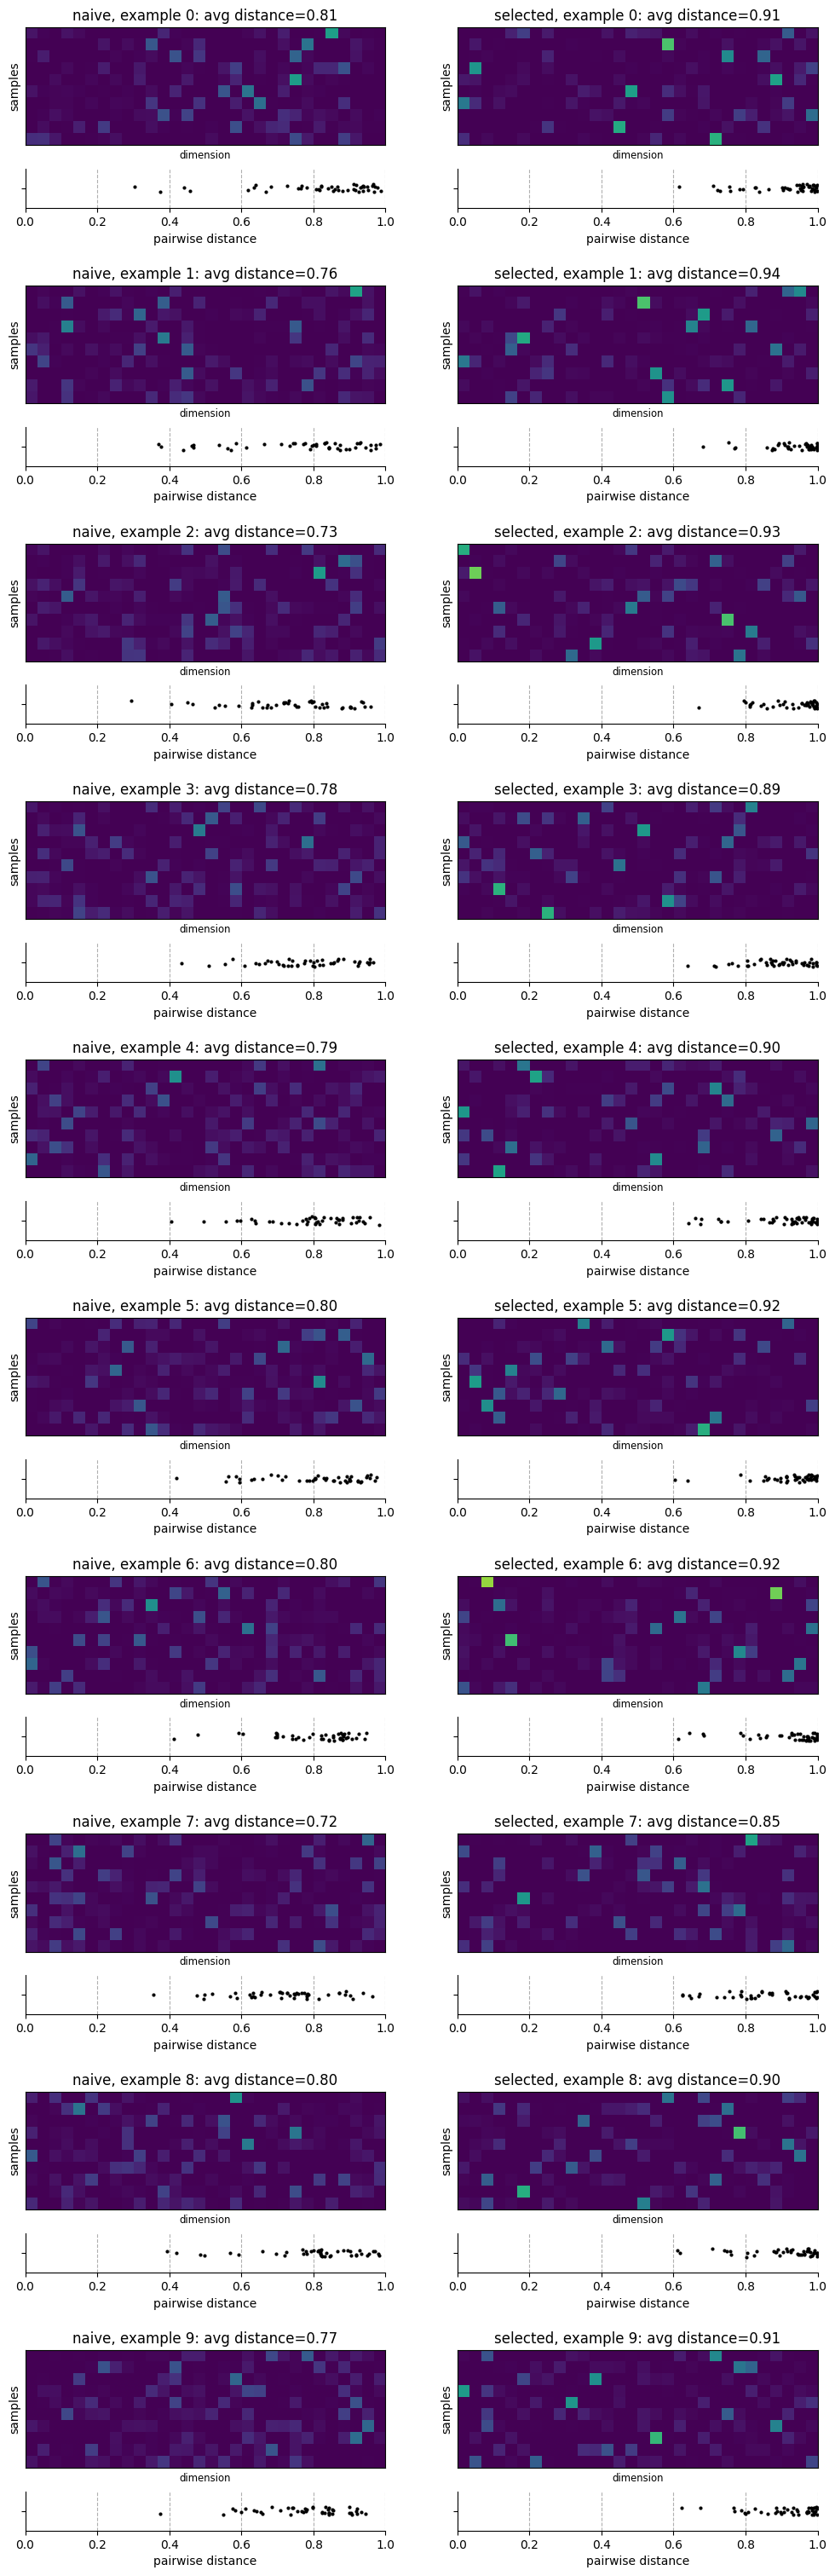

In [15]:
vmax = 1

fig = plt.figure(figsize=(12, n_examples*3))
subfigs = fig.subfigures(nrows=n_examples, ncols=1, hspace=0.1)

for i_example, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=2, ncols=2, height_ratios=[3,1], gridspec_kw={'hspace': 0.3})

    for i_subcol, samples in enumerate([all_naive_samples[i_example], all_selected_samples[i_example]]):
        dists = pdist_jax(samples, dist_fn)

        # First row: plot samples
        ax = axs[0, i_subcol]
        ax.imshow(samples, vmin=0, vmax=vmax, interpolation='none', aspect='auto')
        ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
        ax.set_xlabel('dimension', fontsize='small')
        ax.set_ylabel('samples')
        ax.set_title(f"{['naive', 'selected'][i_subcol]}, example {i_example}: avg distance={dists.mean():.2f}")
        
        # Second row: swarm plot fo dists
        ax = axs[1, i_subcol]
        sns.stripplot(data=dists, orient='h', color='k', size=6, marker='.', ax=ax)
        ax.set_xlabel('pairwise distance'); ax.set_xlim(0,1)
        ax.grid(axis='x', ls='--')
        ax.set_title(f'')
        sns.despine(ax=ax)


All heatmaps values range between 0 and 1.

Through these examples, we find that the average pairwise distance for the naive samples is 0.90, whereas the average pairwsie distances for the selected samples is 0.90.
The pairwise distances in the selected threshold are also significantly right skewed (plus, we have the requirement of pairwise distance threshold of 0.6).
Moreover, the selected samples are qualitatively sparser and more distinct. So, feeling good about this procedure!

## Scaled LDA model

Now, we randomly generate the parameters of our scaled LDA model. We denote the above procedure $\textrm{SeparatedDir}(\alpha)$ to clearly indicate our data-generating process.

In [16]:
key = jr.key(1010110)

vocab_size = 30
n_topics = 6
topic_conc = 0.2
weights_conc = 1.0
scale_concs = jnp.array([1e0, 3, 1e1, 1e3])  # let's vary the scale concentrations

n_docs = 5000
doc_length_rate = 1000

topics_key, scales_key, weights_and_data_key = jr.split(key, 3)

# Sample topics
topics, *_ = generate_separable_dirichlet_samples(
    topics_key, dim=vocab_size, conc=topic_conc, n_samples=n_topics, dist_fn=cosine_dist, threshold=0.6,
)
assert jnp.allclose(topics.sum(axis=-1), 1, atol=0, rtol=1e-3)

# Sample scales from a range of concentrations
scales_by_conc = vmap(
    lambda key, scale: jr.dirichlet(this_key, jnp.broadcast_to(scale, vocab_size))
)(jr.split(scales_key, len(scale_concs)), scale_concs)  # shape (n_concs, vocab_size)

In [17]:
def sample_weights_and_data(
    key: KeyArray, topics: Array, scales: Array, n_docs: int, doc_length_rate: float, weights_conc: float=1.0
):
    """Sample document-topics and data from a scaled LDA model."""

    weights_key, lengths_key, data_key = jr.split(key, 3)

    n_topics, vocab_size = topics.shape

    # Sample document-topic weights, shape (n_docs, n_topics)
    weights_conc_ = jnp.broadcast_to(jnp.asarray(weights_conc, dtype=float), (n_topics,))
    weights = jr.dirichlet(weights_key, weights_conc_, (n_docs,))

    # Sample document lengths, shape (n_docs,)
    lengths = jr.poisson(lengths_key, doc_length_rate, (n_docs,))
    lengths = jnp.asarray(lengths, dtype=float)  # convert to float for tfd.Multinomial

    # Sample data, shape (n_docs, vocab_size)
    probs = scales * (weights @ topics)
    probs /= probs.sum(axis=-1, keepdims=True)
    data = tfd.Multinomial(lengths, probs=probs).sample((), data_key)

    return weights, data
    
# weights_by_conc: shape (n_concs, n_docs, n_topics)
# data_by_conc: shape (n_concs, n_docs, vocab_size)
weights_by_conc, data_by_conc = vmap(
    lambda scales: sample_weights_and_data(
        weights_and_data_key, topics, scales, n_docs, doc_length_rate, weights_conc
    )
)(scales_by_conc)

Text(0.5, 0.0, 'counts per document')

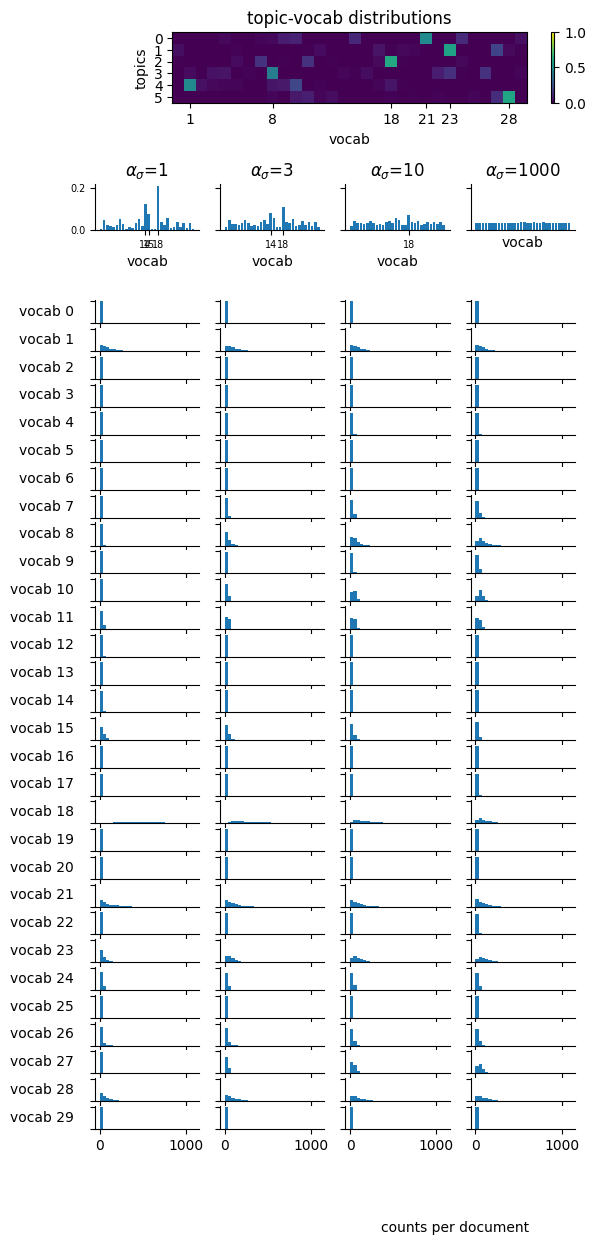

In [18]:
topics_vmax = 1

# Annotate the words that are highly used in the topics
vocab_ticks = onp.nonzero(topics.max(axis=0) > 10/vocab_size)[0]

# Share bin edges
n_bins = 30
max_word_usage = onp.percentile(data_by_conc.sum(axis=-1), 90)
bin_lim = ((max_word_usage // 100) + (max_word_usage % 100 > 1)) * 100
bin_edges = onp.linspace(0, bin_lim, num=n_bins)

# ------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(12, 12))

subfigs = fig.subfigures(nrows=3, ncols=1, height_ratios=[2, 1, 20], hspace=0.2)

# Subfig row 1: Topics (shared by all)
ax = subfigs[0].subplots()
subfigs[0].subplots_adjust(left=0.2, right=0.6)

im = ax.imshow(topics, vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
plt.colorbar(im, ax=ax, fraction=0.05, extend='max' if topics_vmax < 1 else 'neither')
ax.set_ylabel('topics'); ax.set_yticks(range(n_topics))
ax.set_xlabel('vocab')
ax.set_title('topic-vocab distributions', fontsize='large')

# Annotate the words that are highly used in the topics
vocab_ticks = jnp.nonzero(topics.max(axis=0) > 10/vocab_size)[0]
ax.set_xticks(vocab_ticks)

# Subfig row 2: Scales
subfigs[2].subplots_adjust(bottom=0.0, top=1.0)
axs = subfigs[1].subplots(ncols=len(scales_by_conc), sharey=True)
for ax, scales, conc in zip (axs, scales_by_conc, scale_concs):
    ax.bar(range(vocab_size), scales)
    ax.set_title(rf"$\alpha_\sigma$={conc:.0f}", fontsize='large')
    ax.set_xlabel('vocab')

    # Annotate the words that are highly scaled up in the topics
    vocab_ticks = jnp.nonzero(scales > 2/vocab_size)[0]
    ax.set_xticks(vocab_ticks)
    ax.tick_params(bottom=True, labelbottom=True, labelsize='x-small')

    sns.despine(ax=ax)

# Subfig row 3: Empirical word usage count
subfigs[2].subplots_adjust(bottom=0.1, top=1.0)
axs = subfigs[2].subplots(nrows=vocab_size, ncols=len(scales_by_conc), sharex=True, sharey=True)

for i in range(len(scale_concs)):
    for v in range(vocab_size):
        ax = axs[v, i]
        ax.hist(data_by_conc[i,:,v], bin_edges, histtype='stepfilled')
        sns.despine(ax=ax)

for v, ax in enumerate(axs[:,0]):  # first column: label rows with word id, label y-axis
    # ax.set_ylabel("#", fontsize='small')
    ax.tick_params(labelleft=False)
    ax.text(-0.2, 0.5, f"vocab {v}", transform=ax.transAxes, ha='right', va='center', fontsize='medium')

# bottom row: shared x-axis label
plt.text(0.5, 0.0, f"counts per document", transform=subfigs[2].transFigure, ha='center', va='top', fontsize='medium')

**TODO**: To make this plot more clear, we should set the background of every word usage count to a coolwarm plot based on the sigma value, centered around 1/V

We make the following observations:
- Across the topics, vocab 1, 8, 18, 21, 23 and 28 are highly used (threshold: $10/V$)
- Across the scales, using the thresholds of $\alpha_{\sigma,v}\geq2/V$ to determine more usage and $\alpha_{\sigma,v}\leq 0.5/V$ to determine less usage,
    - $\alpha_\sigma=1$:
        - Vocab 14, 15, 18 are highly used
        - Vocab 8 and 23 (among others) are downweighted
    - $\alpha_\sigma=3$: Vocab 14, 18
        - Vocab 14, 18 are highly used
        - Vocab 8 (among others) are downweighted
    - $\alpha_\sigma=10$:
        - Vocab 18 is more used
- In the observed word usages,
    - Vocab 8's usage range decreases as $\alpha_\sigma \downarrow$, consistent with scaled decrease
    - Vocab 18's usage range increases as $\alpha_\sigma \downarrow$, consistent with scaled increase
    - Vocab 1, 21, 23, and 28, which are highly used in the topics and have fairly uniform global usage, have consistent broad distributions.


We aim to infer the underlying topics and the word usage scales across the range of data-generating $\alpha_\sigma$ values.

## EM with PGD algorithm

Our parameter updates for the topics, $\mathbf{\theta}_k \in \Delta_V$ for $k=1,\ldots,K$, involve minimizing the negative log likelihood of a $V$ independent Gamma variables, $f(x)$, subject to $x \in \Delta_V$. The same type of updates are also needed for the weights, $\mathbf{w}_m \in \Delta_K$, and scale, $\sigma\in\Delta_V$ parameters.

Since $f(x)$ is a convex function, one way we can solve this method is through **proximal gradient descent** (see Section 4.2 of Parikh and Boyd (2013)).

The key ingredient is the proximal operator, $\textrm{prox}_{\lambda g}$, for step size $\lambda$ and function $g$. In our case, $g$ is the simplex indicator function,
$g(x) = \begin{cases}0 &\textrm{if } x \in \Delta_V \\ +\infty &\textrm{otherwise}\end{cases}$. The resulting proximal operator of $g$ is simply the projection onto the simplex (see e.g. derivation by [Ang (2023)](https://angms.science/doc/CVX/Proj_simplex.pdf)).
This projection step can be solved with a bisection algorithm (see Section 6.2.25 of Parikh and Boyd (2013)), or more efficiently by sorting (see [Duchi et al. (2008)](https://stanford.edu/~jduchi/projects/DuchiShSiCh08.pdf)),

### Generic PGD with backtracking line search

In [19]:
def prox_grad_descent(objective,
                      prox,
                      init_params,
                      max_num_steps=100,
                      max_num_backtrack_steps=100,
                      max_stepsize=1.0,
                      discount=0.9,
                      tol=1e-6,
                      verbosity=0):
    r""" Run proximal gradient descent on an objective using the given proximal operator.

    prox: params x stepsize -> new_params
    """
    # We need the gradient of the objective
    g = jit(objective)
    dg = jit(grad(objective))

    # Run proximal gradient descent until convergence
    def _step_cond(state):
        _, old_obj, curr_obj, counter = state
        return (abs(curr_obj - old_obj) > tol) & (counter <= max_num_steps)

    def _step_body(state):
        params, _, curr_obj, counter = state

        # Define the condition and body of a while loop for backtracking line search
        def _backtrack_cond(backtrack_state):
            stepsize, backtrack_counter = backtrack_state

            # Compute generalized gradient
            G = (params - prox(params - stepsize * dg(params), stepsize)) / stepsize

            # Update params and evaluate objective
            new_params = params - stepsize * G
            new_obj = g(new_params)

            # Compute upper bound on objective via quadratic Taylor approx
            lower_bound = g(params) \
                - stepsize * jnp.sum(dg(params) * G) \
                    + 0.5 * stepsize * jnp.sum(G**2)

            # Continue to decrease stepsize while objective exceeds lower bound
            return (new_obj > lower_bound) & (backtrack_counter < max_num_backtrack_steps)

        def _backtrack_body(backtrack_state):
            stepsize, backtrack_counter = backtrack_state
            return stepsize * discount, backtrack_counter + 1

        # Run backtracking line search to find stepsize
        stepsize, n_backtrack_steps = lax.while_loop(
            _backtrack_cond, _backtrack_body, (max_stepsize, 0)
        )

        # Perform update with this stepsize
        G = (params - prox(params - stepsize * dg(params), stepsize)) / stepsize
        new_params = params - stepsize * G
        new_obj = g(new_params)
        return new_params, curr_obj, new_obj, counter + 1

    params, _, _, n_steps = lax.while_loop(_step_cond, _step_body, (init_params, jnp.inf, 0.0, 0))
    return params

### Proximal operator to project onto the simplex

Here, we implement the simplex projection function via sorting (Duchi et al. (2008)).

An implementation of the bisection algorithm may be found in earlier notebooks
or in the original ["Convex optimization on simplex by proximal gradient descent (colab)"](https://colab.research.google.com/drive/1SI2MRM_zHfHHwQDbjQORtssg1ixu7v7x?authuser=2#scrollTo=Pa4fo_PWeZnb) notebook.

In [20]:
def project_simplex(w, dummy_stepsize):
    """Project onto simplex following the algorithm described in

    Duchi et al. (2008), https://stanford.edu/~jduchi/projects/DuchiShSiCh08.pdf,
    and following the implementation provided in Wang and Carreira-Perpinan (2013),
    https://home.ttic.edu/~wwang5/papers/SimplexProj.pdf

    Params:
        w: shape [..., D]
    """

    dim = w.shape[-1]

    # sort input vector from highest to lowest elements
    w_sorted = jnp.sort(w, axis=-1, descending=True)

    # enumerate all possible breakpoints
    mus = jnp.cumsum(w_sorted, axis=-1) - 1
    mus /= jnp.arange(dim, dtype=float) + 1

    # find index of last breakpoint for which w_sorted - mu > 0
    j = sum(w_sorted > mus) - 1

    return jnp.maximum(0, w-mus[...,j])

In [21]:
# Let's check that this function does what we expect!
with jnp.printoptions(precision=2):
    for name, w in [
        ("noneg vec", jnp.array([0.2, 0.9, 1.4])),
        ("real vec", jnp.array([-0.4, 0.9, 0.2])),
        ("unit simplex", jnp.array([0.33, 0.33, 0.33])),
        ("a-simplex", jnp.array([3.3, 3.3, 3.3])),
    ]:
        v = project_simplex(w, 0)
        print(f"{name}:\t proj({w})\t-> {v}")
        assert jnp.all(v >= 0) & jnp.isclose(v.sum(), 1.0)

noneg vec:	 proj([0.2 0.9 1.4])	-> [0.   0.25 0.75]
real vec:	 proj([-0.4  0.9  0.2])	-> [0.   0.85 0.15]
unit simplex:	 proj([0.33 0.33 0.33])	-> [0.33 0.33 0.33]
a-simplex:	 proj([3.3 3.3 3.3])	-> [0.33 0.33 0.33]


### Simplex-constrained independent Gamma optimziation

Now, we combine the PGD algorithm and the simplex projection operator with our objective,

$$
\underset{{\mathbf{x} \in \Delta_d}}{\textrm{maximize}}\;
f(\mathbf{x}; \mathbf{\alpha}, \mathbf{\beta}) = \sum_{i=1}^d \ln \textrm{Gamma}(x_i \mid \alpha_i, \beta_i)
$$
whre $\mathbf{\alpha}=(\alpha_1,\ldots, \alpha_d), \mathbf{\beta}=(\beta_1,\ldots,\beta_d)$ are the posterior sufficient statistics.

In [22]:
def gamma_dirichlet_pgd(x0, alpha, beta, amin=1e-4, max_stepsize=1e0, max_num_steps=100):
    
    # Standardize params to be order 1
    c = jnp.maximum(alpha.max(), beta.max())
    alpha = 1. + (alpha-1) / c
    beta = beta / c

    gamma_objective = lambda x: \
        -1.0 * tfd.Gamma(alpha, rate=beta).log_prob(jnp.clip(x, min=amin)).mean()

    return prox_grad_descent(
        gamma_objective, project_simplex, x0,
        max_stepsize=max_stepsize, max_num_steps=max_num_steps
    )

# vmap over initial params, alpha, and beta
v_gamma_dirichlet_pgd = vmap(gamma_dirichlet_pgd, in_axes=(0,0,0,None,None))

### Multinomial log likelihood

We evaluate model fit under a multinomial observation model.

In [23]:
def multinomial_ll(data, topics, weights, scales, scounts=None):
    """Compute multinomial LL of data given model params."""

    probs = scales * (weights @ topics)
    probs /= probs.sum(axis=-1, keepdims=True)

    return tfd.Multinomial(data.sum(axis=-1), probs=probs).log_prob(data)

### EM-PGD

In [24]:
def e_step(data, topics, weights, scales):
    """Compute posterior expected sufficient statistics of parameters.

    Parameters
        X: data tensor, shape (M,V)
        weights: shape (M,K)
        topics: shape (K,V)
        scales: shape (V,)

    Returns
        expected_zs: expected counts allocation, shape (M, K, V)
    """
    rhos = scales * jnp.einsum('mk, kv -> mkv', weights, topics)
    rhos /= jnp.clip(rhos.sum(axis=1, keepdims=True), a_min=1e-4)
    expected_zs = data[:,None,:] * rhos  # shape (M,K,V)
    return expected_zs

In [25]:
def m_step_topics(expected_zs, topics, weights, scales, scounts, prior_params, max_stepsize=1e-1, a_min=1e-4):
    prior_conc, prior_rate = prior_params

    conc = expected_zs.sum(axis=0) + prior_conc
    rate = jnp.einsum('m,v,mk->kv', scounts, scales, weights) + prior_rate
    
    new_topics = v_gamma_dirichlet_pgd(topics, conc, rate, a_min, max_stepsize)
    return new_topics

def m_step_weights(expected_zs, topics, weights, scales, scounts, prior_params, max_stepsize=1e-1, a_min=1e-4):
    prior_conc, prior_rate = prior_params

    conc = expected_zs.sum(axis=-1) + prior_conc
    rate = jnp.einsum('m,v,kv->mk', scounts, scales, topics) + prior_rate

    new_weights = v_gamma_dirichlet_pgd(weights, conc, rate, a_min, max_stepsize)

    return new_weights

def m_step_scales(expected_zs, topics, weights, scales, scounts, prior_params, max_stepsize=1e-1, a_min=1e-4):
    prior_conc, prior_rate = prior_params

    conc = expected_zs.sum(axis=(0,1)) + prior_conc
    rate = jnp.einsum('m,mk,kv->v', scounts, weights, topics) + prior_rate

    new_scales = gamma_dirichlet_pgd(scales, conc, rate, a_min, max_stepsize)

    return new_scales

def m_step_scounts(expected_zs, topics, weights, scales, scounts, prior_params):
    prior_conc, prior_rate = prior_params

    conc = expected_zs.sum(axis=(1,2)) + prior_conc
    rate = jnp.einsum('v,mk,kv->m', scales, weights, topics) + prior_rate
    
    new_scounts = (conc-1) / rate

    return new_scounts

In [26]:
def em(
    data: Array,
    init_topics: Array,
    init_weights: Array,
    init_scales: Array,
    init_scounts: Array,
    prior_topic_shape: float=1.0,
    prior_topic_rate: float=0.0,
    prior_weight_shape: float=1.0,
    prior_weight_rate: float=0.0,
    prior_scale_shape: float=1.0,
    prior_scale_rate: float=0.0,
    prior_scount_shape: float=1.0,
    prior_scount_rate: float=0.0,
    max_em_steps: int=10,
    max_stepsize: dict | float=1e0,
    update_topics: bool=True,
    update_weights: bool=True,
    update_scales: bool=True,
):
    """
    Params
        data: shape (M, D)
        mask: shape (M,)
            Boolean array. If True, use data in training. Else, use data for 
    """

    # Standardize max_stepsize to be dict
    if isinstance(max_stepsize, (int, float)):
        max_stepsize = {param_: max_stepsize for param_ in ('topics', 'weights', 'scales')}
    assert isinstance(max_stepsize, dict)
    
    def step(carry, i):
        topics, weights, scales, scounts = carry

        if update_topics:
            expected_zs = e_step(data, topics, weights, scales)

            topics = m_step_topics(
                expected_zs,
                topics, weights, scales, scounts,
                (prior_topic_shape, prior_topic_rate),
                max_stepsize=max_stepsize['topics']
            )
        
        if update_weights:
            expected_zs = e_step(data, topics, weights, scales)

            weights = m_step_weights(
                expected_zs,
                topics, weights, scales, scounts,
                (prior_weight_shape, prior_weight_rate),
                max_stepsize=max_stepsize['weights']
            )
        
        if update_scales:
            expected_zs = e_step(data, topics, weights, scales)

            scales = m_step_scales(
                expected_zs,
                topics, weights, scales, scounts,
                (prior_scale_shape, prior_scale_rate),
                max_stepsize=max_stepsize['scales']
            )

        # Always update scounts
        expected_zs = e_step(data, topics, weights, scales)

        scounts = m_step_scounts(
            expected_zs,
            topics, weights, scales, scounts,
            (prior_scount_shape, prior_scount_rate),
        )

        ll = multinomial_ll(data, topics, weights, scales).mean()

        return (topics, weights, scales, scounts), (ll, topics, weights, scales, scounts)
    
    _, (all_lls, all_topics, all_weights, all_scales, all_scounts) \
        = jax.lax.scan(step, (init_topics, init_weights, init_scales, init_scounts), length=max_em_steps)

    return all_lls, all_topics, all_weights, all_scales, all_scounts

### Parameter initialization

We initialize the parameters as follows:
\begin{align*}
\mathbf{\theta}_k^{(0)} &\sim \textrm{SeperableDir}(\alpha_\theta) \\
\mathbf{w}_m^{(0)} &\sim \textrm{Dir}(\alpha_w) \\
\sigma_v &= \frac{\textrm{med}\left(\sum_{m=1}^M x_{m,v} \right)}{\textrm{med}\left(\sum_{v'=1}^V \sum_{m=1}^M x_{m,v'}\right)} \\
c_m &= V \sum_{v=1}^V x_{m,v},
\end{align*}
where $\textrm{med}(\cdot)$ is the median function.

Note that the current implementation of $\textrm{SeperableDir}$ cannot be vmapped or jitted.
So, we initialize topics seperately / indepdently and pass them in as required.

In [27]:
def initialize_params(key, data, n_topics, topics_conc=0.5, weights_conc=0.5):
    n_docs, vocab_size = data.shape
    
    topics_key, weights_key = jr.split(key)

    # topics = jr.dirichlet(topics_key, topics_conc*jnp.ones(vocab_size), (n_topics,))

    # topics, *_ = generate_separable_dirichlet_samples(
    #     topics_key, dim=vocab_size, conc=topic_conc, n_samples=n_topics, dist_fn=cosine_dist, threshold=0.6,
    # )

    weights = jr.dirichlet(weights_key, weights_conc*jnp.ones(n_topics), (n_docs,))

    scales = jnp.median(data, axis=0)
    scales /= scales.sum(keepdims=True)
    
    scounts = data.sum(axis=-1) * vocab_size

    # return topics, weights, scales, scounts
    return weights, scales, scounts

## Fitting standard LDA model, $\alpha_\sigma \rightarrow \infty$

First, we attempt to fit data from a standard LDA model ($\alpha_\sigma \rightarrow \infty$).
We use this as a sanity check and a baseline to verify the performance of our EM-PGD algorithm against the variational Bayes (VB) algorithm implemented in the `sklearn` package.

In [28]:
# Use the data generated from above, since we've looked at hard
i_conc = -1

true_params = dict(
    topics = topics, 
    weights=weights_by_conc[i_conc],
    scales = scales_by_conc[i_conc],
)

data = data_by_conc[i_conc]

### VB results

**1. Cross-validate number of topics**

In [35]:
def cross_validate_sklearn(key, data, n_topics, n_folds, n_inits: int=1):
    """K-folds cross-validation using sklearn's VB algorithm."""

    cv_key, _ = jr.split(key)

    n_docs, vocab_size = data.shape

    # Generate holdout masks, shape (n_folds, n_docs//n_folds,)
    # This is the same as in the cross_validate_jax function
    holdout_idxs = jnp.array_split(jr.permutation(cv_key, n_docs), n_folds)
    holdout_idxs = jnp.array([idxs[:n_docs//n_folds] for idxs in holdout_idxs])

    all_train_lls, all_vldtn_lls = [], []
    for _ in range(n_inits):
        this_train_lls, this_vldtn_lls = [], []
        for i_fold in range(n_folds):
            # Get the data split for this fold; this is the same as in the cross_validate_jax function
            idxs = jnp.roll(holdout_idxs, i_fold, axis=0)
            vldtn_data = onp.asarray(jnp.take(data, idxs[0], axis=0, unique_indices=True))
            train_data = onp.asarray(jnp.take(data, idxs[1:].ravel(), axis=0, unique_indices=True))

            # Fit LDA model
            lda = LDA(n_topics)
            lda.fit(train_data)

            topics = jnp.asarray(lda.components_ / lda.components_.sum(axis=1, keepdims=True))
            weights = lda.transform(train_data)
            scales = jnp.ones(vocab_size)/vocab_size  # In standard lda model, scales are just uniform 1/V
            train_lls = multinomial_ll(train_data, topics, weights, scales).mean()

            # Fit the model to held-out data and compute the held-out log likelihood
            vldtn_weights = lda.transform(vldtn_data)
            vldtn_lls = multinomial_ll(vldtn_data, topics, vldtn_weights, scales).mean()

            this_train_lls.append(train_lls)
            this_vldtn_lls.append(vldtn_lls)

        all_train_lls.append(onp.asarray(this_train_lls))
        all_vldtn_lls.append(onp.asarray(this_vldtn_lls))

    return onp.asarray(all_train_lls), onp.asarray(all_vldtn_lls)

In [40]:
# This takes ~ 10 minutes :/
refit = False

if refit:
    n_inits = 2
    n_folds = 3
    n_topics_sweep = jnp.array([2, 4, 6, 8, 10, 20])

    key = jr.key(1712)

    all_train_lls, all_vldtn_lls = [], []
    for n_topics in n_topics_sweep:
        train_lls, vldtn_lls = cross_validate_sklearn(key, data, int(n_topics), n_folds=n_folds, n_inits=n_inits)

        all_train_lls.append(onp.asarray(train_lls).ravel())
        all_vldtn_lls.append(onp.asarray(vldtn_lls).ravel())

    all_train_lls = onp.asarray(all_train_lls)  # shape (n_topics_sweep, n_inits*n_folds)
    all_vldtn_lls = onp.asarray(all_vldtn_lls)

    with open(f"2024-10-10-cv-sklearn.pkl", "wb") as f:
        pickle.dump(
            dict(
                all_train_lls=all_train_lls,
                all_vldtn_lls=all_vldtn_lls,
            ), f
        )

else:
    with open(f"2024-10-10-cv-sklearn.pkl", "rb") as f:
        tmp = pickle.load(f)
        all_train_lls = tmp['all_train_lls']
        all_vldtn_lls = tmp['all_vldtn_lls']


(6, 2, 3)

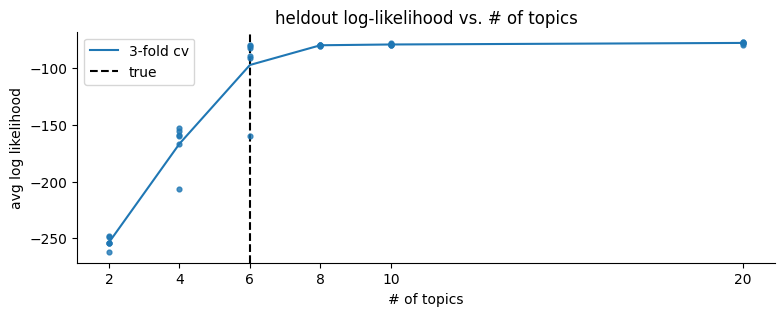

In [53]:
lls = all_vldtn_lls

plt.figure(figsize=(9,3))
ax = plt.gca()

ax.plot(n_topics_sweep, lls.mean(axis=-1),
        color='C0', label=f'{n_folds}-fold cv')
for i, n_topics in enumerate(n_topics_sweep):
    ax.scatter(
        jnp.ones(len(lls[i]))*n_topics, lls[i],
        color='C0', alpha=0.8, marker='o', s=12,
    )

true_n_topics = len(true_params['topics'])
ax.axvline(true_n_topics, color='k', zorder=0, label='true', ls='--')

xticks = onp.unique(
    onp.concatenate([n_topics_sweep, [true_n_topics]])
)
ax.set_xticks(xticks)
# ax.xaxis.set_major_locator(auto_integer_tick_locator)

ax.set_xlabel('# of topics')
ax.set_ylabel('avg log likelihood')

ax.legend()

ax.set_title('heldout log-likelihood vs. # of topics')
sns.despine()

**2. Fit model with most parsimonious number of topics**

The shoulder of the cross-validation curve suggests we choose $\tilde{K} = 8$ topics for the most parsimonious model.

In [49]:
n_topics = 8

all_topics, all_weights, all_lls = [], [], []
for _ in range(n_inits):
    lda = LDA(n_topics)
    weights = lda.fit_transform(data)
    topics = lda.components_ / lda.components_.sum(axis=1, keepdims=True)
    
    scales = jnp.ones(vocab_size)/vocab_size  # In standard lda model, scales are just uniform 1/V

    lls = multinomial_ll(data, topics, weights, scales).mean()

    all_topics.append(topics)
    all_weights.append(weights)
    all_lls.append(lls)

all_topics = onp.asarray(all_topics)
all_weights = onp.asarray(all_weights)
all_lls = onp.asarray(all_lls)

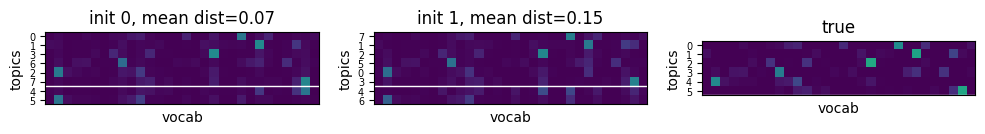

In [58]:
topics_vmax = 1

fig, axs = plt.subplots(nrows=1, ncols=n_inits+1, figsize=(12,6))

dict_of_things = {
    **{f"init {i}": all_topics[i] for i in range(n_inits)},
    "true": true_params['topics']
}

for ax, (name, topics) in zip(axs, dict_of_things.items()):
    # Find the best permutation
    if name != "true":
        cost_matrix = cdist(true_params['topics'], topics, metric='cosine')
        _, i_sorted = linear_sum_assignment(cost_matrix)
        i_discarded = onp.nonzero(onp.isin(onp.arange(len(topics)), i_sorted, invert=True))[0]
        i_permute = onp.concatenate([i_sorted, i_discarded])
        
        final_cost = onp.diag(cost_matrix[:,i_sorted]).sum()
        ax.set_title(f"{name}, mean dist={final_cost:.2f}")
    else:
        i_sorted = i_permute = onp.arange(len(topics))
        ax.set_title(name)

    im = ax.imshow(topics[i_permute], vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
    
    # Draw line to indicate the topics below which have been discarded
    ax.axhline(len(i_sorted)-0.5, color='w', lw=1)

    # Label topics by their original ordering
    ax.set_yticks(onp.arange(len(topics))); ax.set_yticklabels(i_permute)
    
    ax.set_ylabel('topics')
    ax.set_xlabel('vocab'); ax.tick_params(bottom=False, labelbottom=False, labelsize='x-small')
    


Above, we have permuted the fitted topics with knowledge of the true topics to verify that the true topics have been recovered. Now, what metrics can we use to verify that to determine any extraneous topics, _without_ knowledge of the true underlying topics?

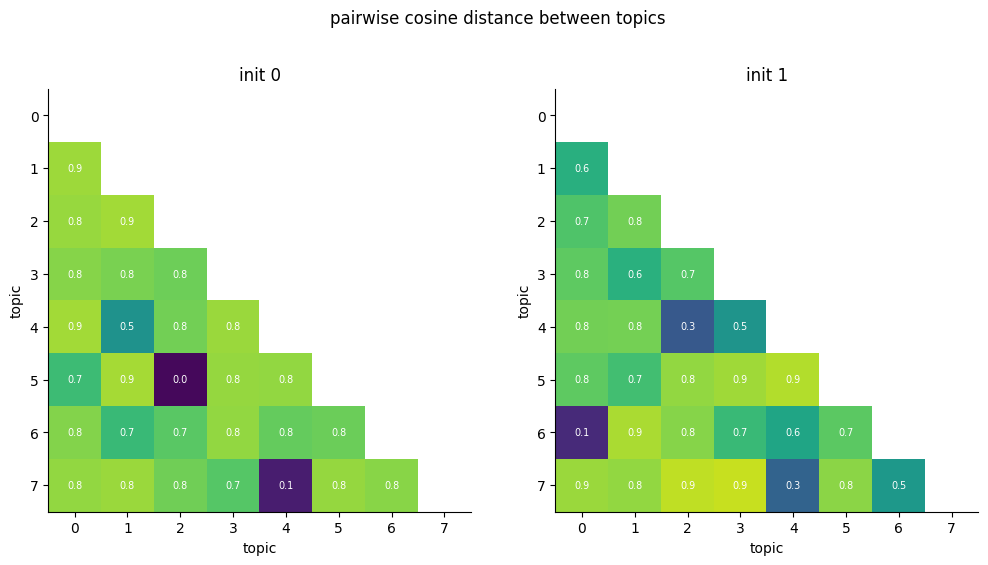

In [62]:
fig, axs = plt.subplots(ncols=n_inits, figsize=(6*n_inits, 6))

# We hide the redundant upper triangular portion of the cost matrix
# to minimize visual overload. Those values are set to NaN / "bad"
cm = plt.get_cmap()
cm.set_bad('white')  # set nans to background color background color

for i_init, (ax, topics) in enumerate(zip(axs, all_topics)):
    # Compute the pairwise cost matrix
    cost_mat = squareform(pdist(topics, metric='cosine'))
    cost_mat_viz = cost_mat + onp.triu(onp.ones_like(cost_mat) * onp.nan)

    ax.imshow(cost_mat_viz, vmin=0, vmax=1, cmap=cm)
    ax.set_xlabel('topic'); ax.set_ylabel('topic')

    # Annotate each distance
    for i, j in onp.stack(onp.tril_indices_from(cost_mat), axis=-1):
        ax.text(j, i, f'{cost_mat[i,j]:.1f}', ha='center', va='center', color='w', fontsize='x-small')

    ax.set_title(f"init {i_init}")

fig.suptitle('pairwise cosine distance between topics')

sns.despine()

Here, we see that topics 2 and 5 are redundant, and topics 0 and 7 are redundant.
One might choose topic 5 over 2, and topic 0 over 7 because these selected maximize the pairwise distances with other topics. It's not immediately clear how to do this evaluation efficiently; this conclusion was just by brute force.

In [66]:
# We can also evaluate LL drop
scales = jnp.ones(vocab_size)/vocab_size

weights = all_weights[1]
    
refr_ll = multinomial_ll(data, topics, weights, scales).mean()  # use ll of full model as reference
    
n_topics = len(topics)

loo_lls = []
for k in range(len(topics)):
    _topics = jnp.roll(topics, k, axis=0)[:-1]
    
    _weights = jnp.roll(weights, k, axis=1)[:, :-1]
    _weights /= _weights.sum(axis=-1, keepdims=True) # restandardize weights; no significant effect in ordering

    loo_ll = multinomial_ll(data, _topics, _weights, scales).mean()

    loo_lls.append(loo_ll)

loo_lls = jnp.array(loo_lls[::-1])

diff = refr_ll - loo_lls
loo_perm = jnp.argsort(diff)[::-1]



Text(0.5, 1.0, 'drop in ll')

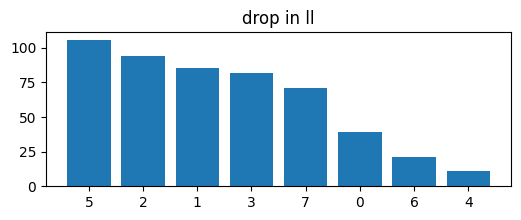

In [67]:
plt.figure(figsize=(6,2))
ax = plt.gca()
ax.bar(range(n_topics), diff[loo_perm])
ax.set_xticks(range(n_topics))
ax.set_xticklabels(loo_perm)
ax.set_title(f"drop in ll")

The drop in LL does not clearly tell us what we should be selection, BUT can be used in conjunction with pairwise distance plot to easily evaluate which of topics 5 and 2 we should drop, which of 0 and 7 we should drop.

**3. Fit model with some extra topics**

We check that this method is also robust to fitting with many more extraneous topcis.

In [116]:
n_topics = 16

all_topics, all_weights, all_lls = [], [], []
for _ in range(n_inits):
    lda = LDA(n_topics)
    weights = lda.fit_transform(data)
    topics = lda.components_ / lda.components_.sum(axis=1, keepdims=True)
    
    scales = jnp.ones(vocab_size)/vocab_size  # In standard lda model, scales are just uniform 1/V

    lls = multinomial_ll(data, topics, weights, scales).mean()

    all_topics.append(topics)
    all_weights.append(weights)
    all_lls.append(lls)

all_topics = onp.asarray(all_topics)
all_weights = onp.asarray(all_weights)
all_lls = onp.asarray(all_lls)

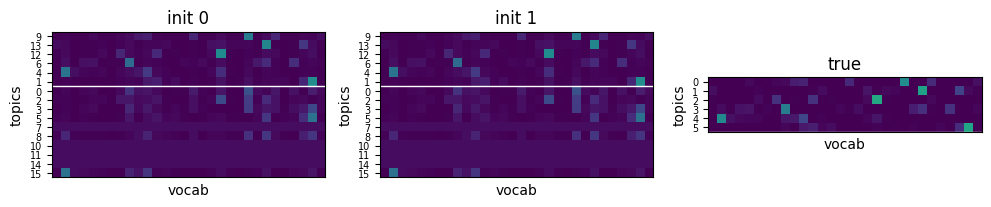

In [117]:
topics_vmax = 1

fig, axs = plt.subplots(nrows=1, ncols=n_inits+1, figsize=(12,6))

dict_of_things = {
    **{f"init {i}": all_topics[0] for i in range(n_inits)},
    "true": true_params['topics']
}

for ax, (name, topics) in zip(axs, dict_of_things.items()):
    # Find the best permutation
    if name != "true":
        cost_matrix = cdist(true_params['topics'], topics, metric='cosine')
        _, i_sorted = linear_sum_assignment(cost_matrix)
        i_discarded = onp.nonzero(onp.isin(onp.arange(len(topics)), i_sorted, invert=True))[0]
        i_permute = onp.concatenate([i_sorted, i_discarded])
    else:
        i_sorted = i_permute = onp.arange(len(topics))

    im = ax.imshow(topics[i_permute], vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
    
    # Draw line to indicate the topics below which have been discarded
    ax.axhline(len(i_sorted)-0.5, color='w', lw=1)

    # Label topics by their original ordering
    ax.set_yticks(onp.arange(len(topics))); ax.set_yticklabels(i_permute)
    
    ax.set_ylabel('topics')
    ax.set_xlabel('vocab'); ax.tick_params(bottom=False, labelbottom=False, labelsize='x-small')
    
    ax.set_title(name)


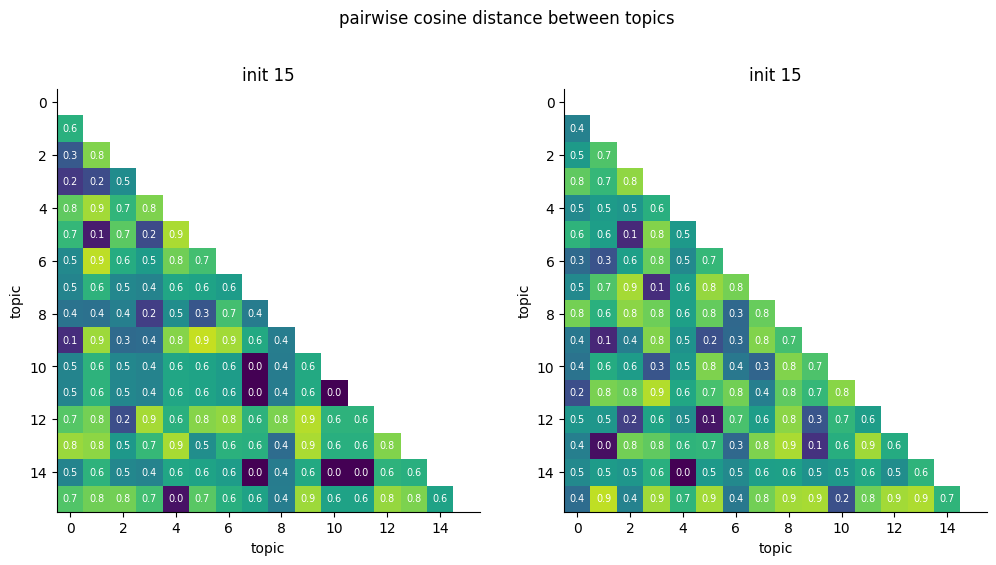

In [127]:
fig, axs = plt.subplots(ncols=n_inits, figsize=(6*n_inits, 6))

# We hide the redundant upper triangular portion of the cost matrix
# to minimize visual overload. Those values are set to NaN / "bad"
cm = plt.get_cmap()
cm.set_bad('white')  # set nans to background color background color

for i, (ax, topics) in enumerate(zip(axs, all_topics)):
    # Compute the pairwise cost matrix
    cost_mat = squareform(pdist(topics, metric='cosine'))
    cost_mat_viz = cost_mat + onp.triu(onp.ones_like(cost_mat) * onp.nan)

    ax.imshow(cost_mat_viz, vmin=0, vmax=1, cmap=cm)
    ax.set_xlabel('topic'); ax.set_ylabel('topic')

    # Annotate each distance
    for i, j in onp.stack(onp.tril_indices_from(cost_mat), axis=-1):
        ax.text(j, i, f'{cost_mat[i,j]:.1f}', ha='center', va='center', color='w', fontsize='x-small')

    ax.set_title(f"init {i}")

fig.suptitle('pairwise cosine distance between topics')

sns.despine()

In [ ]:
# We can also evaluate LL drop
def leave_out_ll(carry, k):
    """Compute log likelihood leaving out the k-th topic"""

    _topics = jnp.roll(topics, k, axis=0)[:-1]
    
    _weights = jnp.roll(weights, k, axis=1)[:, :-1]
    _weights /= _weights.sum(axis=-1, keepdims=True) # restandardize weights; no significant effect in ordering

    ll = multinomial_ll(data, _topics, _weights, scales).mean()

    return None, ll

    


scales = jnp.ones(vocab_size)/vocab_size

weights = all_weights[0]
    
refr_ll = multinomial_ll(data, topics, weights, scales).mean()  # use ll of full model as reference
    
n_topics = len(topics)

loo_lls = []
for k in range(len(topics)):
    _topics = jnp.roll(topics, k, axis=0)[:-1]
    
    _weights = jnp.roll(weights, k, axis=1)[:, :-1]
    _weights /= _weights.sum(axis=-1, keepdims=True) # restandardize weights; no significant effect in ordering

    loo_ll = multinomial_ll(data, _topics, _weights, scales).mean()

    loo_lls.append(loo_ll)

loo_lls = jnp.array(loo_lls[::-1])

diff = refr_ll - loo_lls
loo_perm = jnp.argsort(diff)[::-1]



### EM-PGD results

**1. Cross-validate number of topcis**

In [60]:
def cross_validate(key, n_topics, n_folds, data, init_topics, n_train_steps, n_vldtn_steps, max_stepsize=1e0):
    """K-folds cross-validation.

    We currently cannot vmap over the parameter initializations due the generate_seperable_dirichlet_samples function.
    So we pass them in. We will be a bit lazy for now and reuse the same param inits across all folds.

    Parameters
        key:
        n_folds: int
        data: shape (n_docs, vocab_size)
        init_topics: shape (n_topics, vocab_size)
        ...
        prior_params

    """

    cv_key, init_key = jr.split(key)

    n_docs, vocab_size = data.shape

    # Generate holdout masks, shape (n_folds, n_docs//n_folds,)
    holdout_idxs = jnp.array_split(jr.permutation(cv_key, n_docs), n_folds)
    holdout_idxs = jnp.array([idxs[:n_docs//n_folds] for idxs in holdout_idxs])

    # Don't use masking; this would require fitting weights for all of the data,
    # then just computing ll off of a very small subset. Instead, split train
    # and vldtn datas by rolling through holdout idxs

    fit = partial(em, max_em_steps=n_train_steps, max_stepsize=max_stepsize,)
    partial_fit = partial(em, max_em_steps=n_vldtn_steps, max_stepsize=max_stepsize, update_topics=False, update_scales=False)

    def cv_fold(i_fold):
        train_key, vldtn_key = jr.split(jr.fold_in(init_key, i_fold))

        idxs = jnp.roll(holdout_idxs, i_fold, axis=0)
        vldtn_data = jnp.take(data, idxs[0], axis=0, unique_indices=True)
        train_data = jnp.take(data, idxs[1:].ravel(), axis=0, unique_indices=True)

        # init_topics, init_weights, init_scales, init_scounts\
        #     = initialize_params(train_key, train_data, n_topics, use_for_loop=False)
        init_weights, init_scales, init_scounts = initialize_params(train_key, train_data, n_topics)
        
        all_lls, all_topics, _, all_scales, _ = fit(
            train_data, init_topics, init_weights, init_scales, init_scounts, 
        )

        fitted_topics, fitted_scales = all_topics[-1], all_scales[-1]

        # Draw a new set of validation weights
        init_vldtn_weights, _, _ = initialize_params(vldtn_key, vldtn_data, n_topics)

        # Manually perform an M-step to get scounts
        init_vldtn_scounts = vldtn_data.sum(axis=-1)  # equivalent to expected_zs.sum(axis=(1,2))
        init_vldtn_scounts /= jnp.einsum('v,mk,kv->m', fitted_scales, init_vldtn_weights, fitted_topics)

        # initialize with original weights
        vldtn_lls, *_ = partial_fit(
            vldtn_data, fitted_topics, init_vldtn_weights, fitted_scales, init_vldtn_scounts,
        )

        return all_lls, vldtn_lls

    train_lls, vldtn_lls = vmap(cv_fold)(jnp.arange(n_folds))

    return train_lls, vldtn_lls

In [72]:
n_folds = 3
n_inits = 5

n_train_steps = 200
n_vldtn_steps = 50
max_stepsize = 1e0

# n_topics_sweep = jnp.array([2, 4, 6, 8, 10, 20])  # 9m 22s
n_topics_sweep = jnp.array([6, 8, 10, 20])  # 9m 22s

keys = jr.split(jr.key(49328), n_inits)

# (n_inits, n_folds, n_steps)
# all_train_lls_by_iter, all_vldtn_lls_by_iter = [], []
for n_topics in n_topics_sweep:
    # Currently, initialize parameters outside of the cross-validation function
    # because of non-jittability / non-vmappability of generate_seperable_dirichlet_samples
    # shape (n_inits, n_topics, vocab_size)
    all_init_topics = jnp.stack([
        generate_separable_dirichlet_samples(key, vocab_size, n_topics, conc=1.0, threshold=0.4, n_simulated=500)[0] for key in keys
    ], axis=0)
    assert jnp.allclose(all_init_topics.sum(axis=-1), 1, rtol=1e-1)

    train_lls, vldtn_lls = vmap(
        lambda key, init_topics: cross_validate(
                key, n_topics, n_folds, data, init_topics, n_train_steps, n_vldtn_steps, max_stepsize
        ),
    )(keys, all_init_topics)

    all_train_lls_by_iter.append(train_lls.reshape(-1, n_train_steps))
    all_vldtn_lls_by_iter.append(vldtn_lls.reshape(-1, n_vldtn_steps))

# shape (n_topics_sweep, n_folds * n_inits, n_{train/vldtn}_steps)
all_train_lls_by_iter = jnp.stack(all_train_lls_by_iter, axis=0)
all_vldtn_lls_by_iter = jnp.stack(all_vldtn_lls_by_iter, axis=0)

IndexError: list index out of range

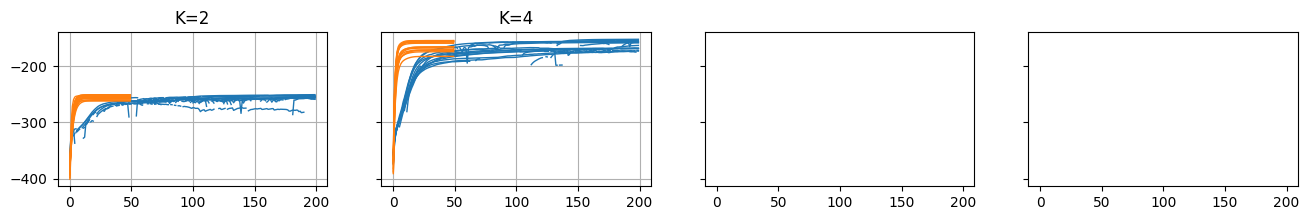

In [71]:
n_conditions = len(all_train_lls_by_iter)

ncols = 4
nrows = n_conditions // ncols + (n_conditions % ncols > 1)

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, sharex=True, sharey=True,
    figsize=(4*ncols, 2*nrows)
)

for i, ax in enumerate(axs.ravel()):
    n_topics = n_topics_sweep[i]
    ax.plot(all_train_lls_by_iter[i].T, color='C0', lw=1)
    ax.plot(all_vldtn_lls_by_iter[i].T, color='C1', lw=1)
    ax.set_title(f"K={n_topics}")
    ax.grid(True)

fig.suptitle('training + validation log likelihoods vs. iteration', y=1.0)
sns.despine()

*TODO* Temporarily skipping full CV, slower than I had hoped running 200 iters. Maybe it has to do with running on `dev` parition and now `swl1`... In any case, let's assyme that shoulder also occurs at K=8.

**2. Fit model with most parsimonious number of topics**

The shoulder of the cross-validation curve suggests we choose $\tilde{K} = 8$ topics for the most parsimonious model.

In [68]:
# Execution time: ~2.5-3.5 min
n_topics = 8
n_inits = 2
n_steps = 100
max_stepsize = 1e0

key = jr.key(3420)
topic_key, init_key = jr.split(key)

# Currently, initialize parameters outside of the cross-validation function
# because of non-jittability / non-vmappability of generate_seperable_dirichlet_samples
# shape (n_inits, n_topics, vocab_size)
# all_init_topics = jnp.stack([
#     generate_separable_dirichlet_samples(key, vocab_size, n_topics, conc=1.0, threshold=0.4, n_simulated=500)[0]
#     for key in jr.split(topic_key, n_inits)
# ], axis=0)

# DEBUGGING: Sample init topics from regular dirichlet -- reduced bumps and nans in ll, but did not remove. indicates some sort of instability
all_init_topics = jr.dirichlet(topic_key, jnp.ones(vocab_size), shape=(n_inits, n_topics))
assert jnp.allclose(all_init_topics.sum(axis=-1), 1, rtol=1e-1)

all_init_weights, all_init_scales, all_init_scounts = vmap(
    initialize_params, in_axes=(0,None,None)
)(jr.split(init_key, n_inits), data, n_topics)

# DEBUGGING: Initialize scales to uniform
# all_init_scales = jr.dirichlet(topic_key, 5*jnp.ones(vocab_size), shape=(n_inits))  # would want to increase prior concentration to achieve more stbale fitting
# all_init_scales = jnp.ones((n_inits, vocab_size))/vocab_size  # This stabilizes it!

all_lls, all_topics, all_weights, all_scales, all_scounts = vmap(
    lambda topics, weights, scales, scounts: em(
        data, topics, weights, scales, scounts, 
        prior_scale_shape=1e6,
        max_em_steps=n_steps, max_stepsize=max_stepsize,
    )
)(all_init_topics, all_init_weights, all_init_scales, all_init_scounts)

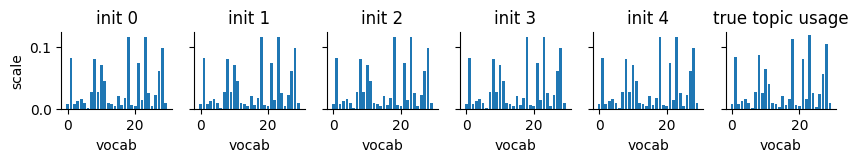

In [62]:
# Initialization with empirical median usage
all_init_scales = all_init_others[-2]

fig, axs = plt.subplots(ncols=n_inits+1, sharey=True, figsize=(10,1))

for i, (ax, init_scales) in enumerate(zip(axs, all_init_scales)):
    ax.bar(range(vocab_size), init_scales)
    ax.set_xlabel('vocab')
    ax.set_title(f"init {i}")

ax = axs[-1]
topic_word_usage = true_params['topics'].sum(axis=0)
topic_word_usage /= topic_word_usage.sum()
ax.bar(range(vocab_size), topic_word_usage)
ax.set_title('true topic usage')
ax.set_xlabel('vocab')

axs[0].set_ylabel('scale')
    
sns.despine()


Perhaps a key thing that we're overlooking and that is making global word usage scales difficult to identify, is that the topics themselves don't use the words uniformly.
Here, I am plotting the initial scales, which are the empirical median usage.
On the far right, I have plotting the empirical usage of words, across all of the topics (assuming average equal usage). They look nearly idential.

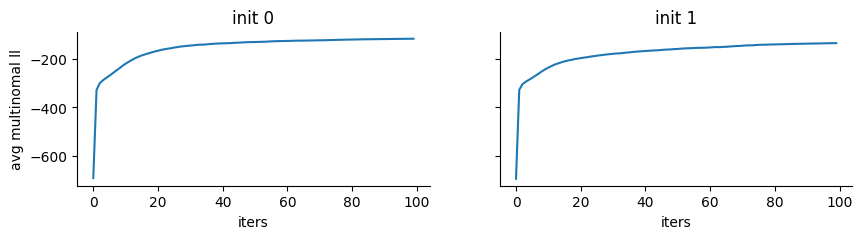

In [69]:
fig, axs = plt.subplots(ncols=n_inits, sharey=True, figsize=(10,2))

for i, (ax, lls) in enumerate(zip(axs, all_lls)):
    ax.plot(lls.T)
    ax.set_xlabel('iters')
    ax.set_title(f"init {i}")

axs[0].set_ylabel('avg multinomal ll')
    
sns.despine()

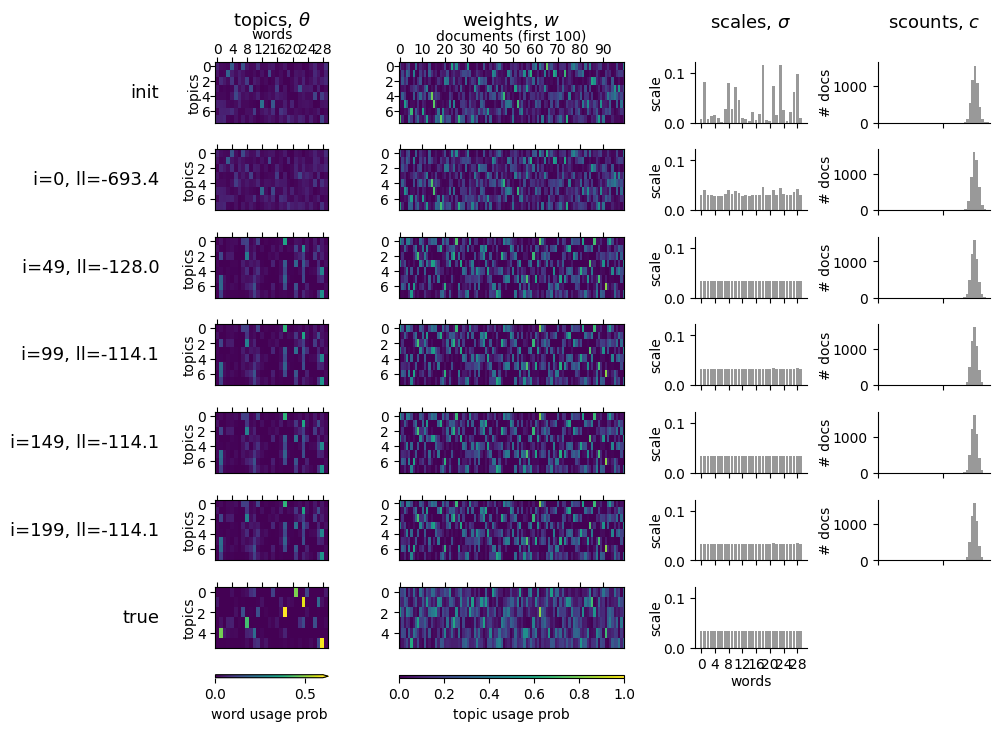

In [70]:
i_init = 0
iters_to_plot = [64, 65, 68, 71, 75]

dict_of_params = {
    "init": Params(all_init_topics[i_init], all_init_weights[i_init], all_init_scales[i_init], all_init_scounts[i_init]),
    **{
        f"i={i}, ll={all_lls[i_init,i]:.1f}": Params(all_topics[i_init,i], all_weights[i_init,i], all_scales[i_init,i], all_scounts[i_init,i])
        for i in onp.linspace(0, 199, num = 5, dtype=int)
    },
    "true": Params(true_params['topics'], true_params['weights'], jnp.ones(vocab_size)/vocab_size)
}
compare_params(dict_of_params, topic_vmax=0.6);

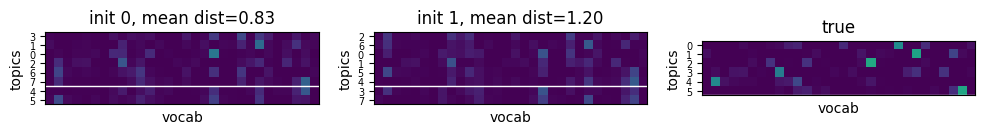

In [72]:
topics_vmax = 1

fig, axs = plt.subplots(nrows=1, ncols=n_inits+1, figsize=(12,6))

dict_of_things = {
    **{f"init {i}": all_topics[i,-1] for i in range(n_inits)},
    "true": true_params['topics']
}

for ax, (name, topics) in zip(axs, dict_of_things.items()):
    # Find the best permutation
    if name != "true":
        cost_matrix = cdist(true_params['topics'], topics, metric='cosine')
        _, i_sorted = linear_sum_assignment(cost_matrix)
        i_discarded = onp.nonzero(onp.isin(onp.arange(len(topics)), i_sorted, invert=True))[0]
        i_permute = onp.concatenate([i_sorted, i_discarded])
        
        final_cost = onp.diag(cost_matrix[:,i_sorted]).sum()
        ax.set_title(f"{name}, mean dist={final_cost:.2f}")
    else:
        i_sorted = i_permute = onp.arange(len(topics))
        ax.set_title(name)

    im = ax.imshow(topics[i_permute], vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
    
    # Draw line to indicate the topics below which have been discarded
    ax.axhline(len(i_sorted)-0.5, color='w', lw=1)

    # Label topics by their original ordering
    ax.set_yticks(onp.arange(len(topics))); ax.set_yticklabels(i_permute)
    
    ax.set_ylabel('topics')
    ax.set_xlabel('vocab'); ax.tick_params(bottom=False, labelbottom=False, labelsize='x-small')
    


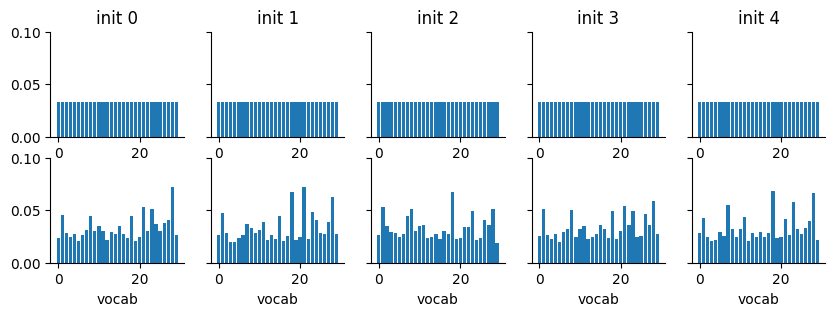

In [78]:
# Initialization with Dir(5)
fig, axs = plt.subplots(ncols=n_inits, nrows=2, sharey=True, figsize=(10,3))

for i, (ax, init_scales) in enumerate(zip(axs[0], all_init_scales)):
    ax.bar(range(vocab_size), init_scales)
    ax.set_xlabel('vocab')
    ax.set_title(f"init {i}")
    ax.set_ylim(top=0.1)

for i, (ax, scales) in enumerate(zip(axs[-1], all_scales[:,-1])):
    ax.bar(range(vocab_size), scales)
    ax.set_xlabel('vocab')
    ax.set_ylim(top=0.1)

# axs[0].set_ylabel('scale')
    
sns.despine()


### Infer parameters with variational Bayes

In [46]:
# still need this for the compare_params plotting function
Params = namedtuple("Params", ["topics", "weights", "scales", "scounts"], defaults=[None, None])

def compare_params(
    dict_of_params, fig=None,
    topic_vmax: float=1.0,
    weight_vmax: float=1.0,
    max_n_vocab_ticks: int=10,
    max_n_topic_ticks: int=5,
    max_n_docs: int=100,
):
    tickpad = 0.05
    vocab_ticker = mpl.ticker.MaxNLocator(max_n_vocab_ticks, integer=True)
    topic_ticker = mpl.ticker.MaxNLocator(max_n_topic_ticks, integer=True)

    for params in dict_of_params.values():
        n_docs = len(params.weights)
        break
    
    n_param_sets = len(dict_of_params)

    fig, all_axs = plt.subplots(
        nrows=n_param_sets+1, height_ratios=(1,)*n_param_sets + (0.05,),
        ncols=4, width_ratios=(1,2,1,1),
        gridspec_kw={"hspace": 0.5, "wspace": 0.5},
        figsize=(10,len(dict_of_params)+1)
    )

    # ======================================================
    # Topics (heatmap)
    # ======================================================
    i_col = 0
    axs, cax = all_axs[:-1,i_col], all_axs[-1,i_col]

    for ax, params in zip(axs, dict_of_params.values()):
        n_topics, vocab_size = params.topics.shape
        im = ax.imshow(params.topics, vmin=0, vmax=topic_vmax, aspect="auto", interpolation="none")
        
        # x-axis: vocab
        ax.xaxis.set_major_locator(vocab_ticker)
        ax.tick_params(top=True, labeltop=False, bottom=False, labelbottom=False)

        # y-axis: topics
        ax.set_ylabel("topics", labelpad=0)
        ax.yaxis.set_major_locator(topic_ticker)

    # Label x-axis of top row
    axs[0].set_xlabel(f"words", labelpad=3)
    axs[0].xaxis.set_label_position('top')
    axs[0].tick_params(top=True, labeltop=True, pad=tickpad)

    # Show colorbar
    plt.colorbar(im, cax=cax, location='bottom', label='word usage prob',
                 extend="max" if topic_vmax < 1 else "neither")

    # ======================================================
    # Weights (heatmap)
    # ======================================================
    i_col = 1
    axs, cax = all_axs[:-1,i_col], all_axs[-1,i_col]

    n = 100
    for ax, params in zip(axs, dict_of_params.values()):
        n_docs, n_topics = params.weights.shape
        im = ax.imshow(params.weights[:n].T, vmin=0, vmax=weight_vmax, aspect="auto", interpolation="none")
        
        # x-axis: docs
        ax.set_xticks(jnp.linspace(0, n, num=min(10, n), endpoint=False));
        ax.tick_params(top=True, labeltop=False, bottom=False, labelbottom=False)

        # y-axis: topics
        # ax.set_ylabel("topics", labelpad=0);  # use the ylabels from topics
        ax.yaxis.set_major_locator(topic_ticker)

    # Label x-axis of top row
    axs[0].set_xlabel(f"documents (first {n})", labelpad=2, )
    axs[0].xaxis.set_label_position('top')
    axs[0].tick_params(top=True, labeltop=True, bottom=False, pad=tickpad)

    # colorbar
    plt.colorbar(im, cax=cax, location='bottom', label='topic usage prob',
                 extend="max" if weight_vmax < 1 else "neither")

    # ======================================================
    # Scales (bar plot)
    # ======================================================
    i_col = 2
    axs, cax = all_axs[:-1,i_col], all_axs[-1,i_col]
    cax.remove()  # no colorbar needed

    ymax = 0
    for ax, params in zip(axs, dict_of_params.values()):
        if params.scales is None:
            ax.remove()
        else:
            ax.bar(range(vocab_size), params.scales, fc='0.6')
            
            # x-axis: vocab
            ax.xaxis.set_major_locator(vocab_ticker)
            ax.tick_params(labelbottom=False)  # only show ticks for last row

            # y-axis: scales
            ax.set_ylabel("scale", labelpad=0)
    
            ymax = max(ymax, ax.get_ylim()[1])

            sns.despine(ax=ax)
    
    # manually share y-axis
    for ax, params in zip(axs, dict_of_params.values()):
        if params.scales is not None:
            ax.set_ylim(top=ymax)

    ax.set_xlabel(f"words", labelpad=2); ax.tick_params(labelbottom=True)

    # ======================================================
    # Scounts (histogram)
    # ======================================================
    i_col = 3
    axs, cax = all_axs[:-1,i_col], all_axs[-1,i_col]
    cax.remove()  # no colorbar needed

    xmax, ymax = 0, 0
    for ax, params in zip(axs, dict_of_params.values()):
        if params.scounts is not None:
            ax.hist(params.scounts, fc='0.6')
            ax.tick_params(labelbottom=False)
            ax.set_xlim(left=0)
            sns.despine(ax=ax)
            ax.set_ylabel("# docs", labelpad=0.)
            
            ymax = max(ymax, ax.get_ylim()[1])
            xmax = max(xmax, ax.get_xlim()[1])
        
        else: 
            ax.remove()
    
    # manually share x-axis and y-axis
    for ax, params in zip(axs, dict_of_params.values()):
        if params.scounts is not None:
            ax.set_ylim(top=ymax)
            ax.set_xlim(right=xmax)

    ax.set_xlabel(f"scounts", labelpad=2); ax.tick_params(labelbottom=True)

    # ======================================================
    # Super-labels
    # ======================================================
    # Rows: Parameter set name
    for ax, name in zip(all_axs[:-1,0], dict_of_params.keys()):
        ax.text(-0.5, 0.5, name, ha='right', va='center', fontsize=13, transform=ax.transAxes)

    # Columns: Parameter names
    for ax, name in zip(all_axs[0], [r"topics, $\theta$", r"weights, $w$", r"scales, $\sigma$", r"scounts, $c$"]):
        ax.text(0.5, 1.5, name, ha='center', va='bottom', fontsize=13, transform=ax.transAxes)

    return fig

# fig = compare_params(
#     {"vb": vb_params, "true": true_params,},
#     topic_vmax=0.3,
#     max_n_vocab_ticks=5,
#     max_n_topic_ticks=3,
#     max_n_docs=50,
# )

**Figure** Inference under the standard LDA model using variational Bayes does not recover the data-generating topics.
Instead, it places (relatively) too much mass on words 3 and 4, which make up a significant portion of observed word counts.

### Cross-validate to identify number of topics $\tilde{K}$

Not the most proper cross validation. Doing 1 mask for 5 different inits.

In [58]:
def cross_validate(key, n_topics, n_folds, data, prior_params, n_train_steps, n_vldtn_steps, max_stepsize=1e0):
    """K-folds cross-validation.

    Parameters
        key:
        n_folds: int
        data: shape (n_docs, vocab_size)
        topics: shape (n_topics, vocab_size)
        ...
        prior_params

    """

    cv_key, init_key = jr.split(key)

    n_docs, vocab_size = data.shape

    # Generate holdout masks, shape (n_folds, n_docs//n_folds,)
    holdout_idxs = jnp.array_split(jr.permutation(cv_key, n_docs), n_folds)
    holdout_idxs = jnp.array([idxs[:n_docs//n_folds] for idxs in holdout_idxs])

    # Don't use masking; this would require fitting weights for all of the data,
    # then just computing ll off of a very small subset. Instead, split train
    # and vldtn datas by rolling through holdout idxs

    fit = partial(em, prior_params=prior_params, max_em_steps=n_train_steps, max_stepsize=max_stepsize,)
    partial_fit = partial(em, prior_params=prior_params, max_em_steps=n_vldtn_steps, max_stepsize=max_stepsize, update_topics=False, update_scales=False)

    def cv_fold(i_fold):
        train_key, vldtn_key = jr.split(jr.fold_in(init_key, i_fold))

        idxs = jnp.roll(holdout_idxs, i_fold, axis=0)
        vldtn_data = jnp.take(data, idxs[0], axis=0, unique_indices=True)
        train_data = jnp.take(data, idxs[1:].ravel(), axis=0, unique_indices=True)

        init_topics, init_weights, init_scales, init_scounts\
            = initialize_params(train_key, train_data, n_topics)
        
        all_lls, all_topics, _, all_scales, _ = fit(
            init_topics, init_weights, init_scales, init_scounts, train_data,
        )

        fitted_topics, fitted_scales = all_topics[-1], all_scales[-1]

        # Draw a new set of validation weights
        _, init_vldtn_weights, _, _ = initialize_params(vldtn_key, vldtn_data, n_topics)

        # Manually perform an M-step to get scounts
        init_vldtn_scounts = vldtn_data.sum(axis=-1)  # equivalent to expected_zs.sum(axis=(1,2))
        init_vldtn_scounts /= jnp.einsum('v,mk,kv->m', fitted_scales, init_vldtn_weights, fitted_topics)

        # initialize with original weights
        vldtn_lls, *_ = partial_fit(
            fitted_topics, init_vldtn_weights, fitted_scales, init_vldtn_scounts, vldtn_data,
        )

        return all_lls, vldtn_lls

    train_lls, vldtn_lls = vmap(cv_fold)(jnp.arange(n_folds))

    return train_lls, vldtn_lls

In [90]:
n_folds = 3
n_inits = 5
n_train_steps = 100
n_vldtn_steps = 50
max_stepsize = 1e0

n_topics_sweep = jnp.array([2, 4, 6, 8, 10, 12, 20])  # 9m 22s

keys = jr.split(jr.key(49328), n_inits)

# (n_inits, n_folds, n_steps)
all_train_lls, all_vldtn_lls = [], []
for n_topics in n_topics_sweep:
    train_lls, vldtn_lls = vmap(
        lambda key: cross_validate(
                key, n_topics, n_folds, data, prior_params, n_train_steps, n_vldtn_steps, max_stepsize
        ),
    )(keys)

    all_train_lls.append(train_lls.reshape(-1, n_train_steps))
    all_vldtn_lls.append(vldtn_lls.reshape(-1, n_vldtn_steps))

# shape (n_topics_sweep, n_folds * n_inits, n_{train/vldtn}_steps)
all_train_lls = jnp.stack(all_train_lls, axis=0)
all_vldtn_lls = jnp.stack(all_vldtn_lls, axis=0)

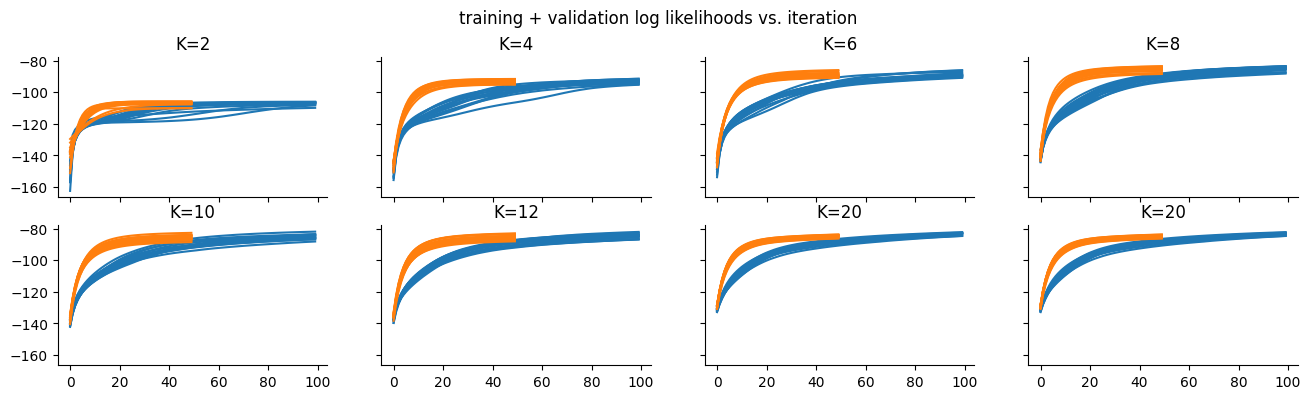

In [138]:
n_conditions = len(all_train_lls)

ncols = 4
nrows = n_conditions // ncols + (n_conditions % ncols > 1)

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, sharex=True, sharey=True,
    figsize=(4*ncols, 2*nrows)
)

for i, ax in enumerate(axs.ravel()):
    n_topics = n_topics_sweep[i]
    ax.plot(all_train_lls[i].T, color='C0')
    ax.plot(all_vldtn_lls[i].T, color='C1')
    ax.set_title(f"K={n_topics}")

fig.suptitle('training + validation log likelihoods vs. iteration', y=1.0)
sns.despine()

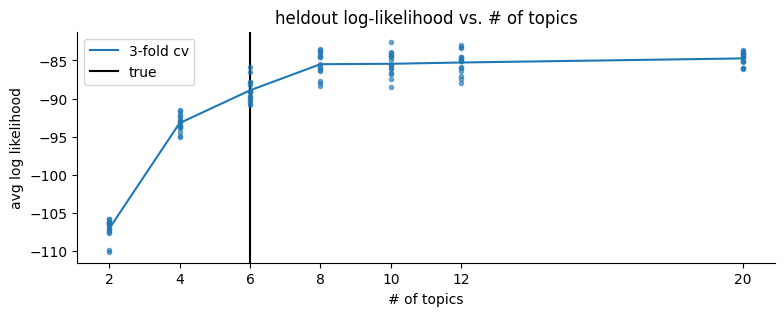

In [136]:
final_vldtn_lls = all_vldtn_lls[...,-1]

plt.figure(figsize=(9,3))
ax = plt.gca()

ax.plot(n_topics_sweep, final_vldtn_lls.mean(axis=-1),
        color='C0', label=f'{n_folds}-fold cv')
for i, n_topics in enumerate(n_topics_sweep):
    ax.scatter(
        jnp.ones(len(lls))*n_topics, final_vldtn_lls[i],
        color='C0', alpha=0.6, marker='.'
    )

true_n_topics = len(true_params.topics)
ax.axvline(true_n_topics, color='k', zorder=0, label='true')

xticks = onp.unique(
    onp.concatenate([n_topics_sweep, [true_n_topics]])
)
ax.set_xticks(xticks)
# ax.xaxis.set_major_locator(auto_integer_tick_locator)

ax.set_xlabel('# of topics')
ax.set_ylabel('avg log likelihood')

ax.legend()

ax.set_title('heldout log-likelihood vs. # of topics')
sns.despine()

The cross-validation results suggest that that the optimal number of topics is $\tilde{K}=8$.

### Examine parameters of fitted model

In [26]:
# ~1 min on swl1 partition, after algorithms have been compiled and without saving
# ~3 min on dev partition, without compilation and with saving
max_stepsize = 1
max_em_steps = 200
prior_params = PriorParams()

n_topics = 8  # found via cross-validation
n_inits = 5
init_key = jr.key(1748)

batched_init_params = vmap(
    initialize_params, in_axes=(0,None,None)
)(jr.split(init_key, n_inits), data, n_topics)

# leading shapes (n_inits, max_em-steps, ...)
all_lls, all_topics, all_weights, all_scales, all_scounts = vmap(
    lambda topics, weights, scales, scounts: em(
        topics, weights, scales, scounts, data, 
        prior_params=prior_params, max_em_steps=max_em_steps, max_stepsize=max_stepsize,
    )
)(*batched_init_params)

# # Save parameters
# with open(f"2024-10-07-K={n_topics}.pkl", "wb") as f:
#     pickle.dump(
#         dict(
#             true_params=true_params,
#             batched_init_params=batched_init_params,
#             all_topics=all_topics,
#             all_weights=all_weights,
#             all_scales=all_scales,
#             all_scounts=all_scounts,
#             all_lls=all_lls,
#             init_key=init_key,
#             prior_params=prior_params,
#             max_stepsize=max_stepsize,
#         ),
#         f,
#     )

In [ ]:
# Load saved parameters
with open(f"2024-10-07-K=8.pkl", "rb") as f:
    tmp = pickle.load(f)

    true_params = tmp['true_params']
    batched_init_params = tmp['batched_init_params']
    all_topics = tmp['all_topics']
    all_weights = tmp['all_weights']
    all_scales = tmp['all_scales']
    all_scounts = tmp['all_scounts']
    all_lls = tmp['all_lls']
    # init_key = tmp['init_key']
    # prior_params = tmp['prior_params']
    # max_stepsize = tmp['max_stepsize']

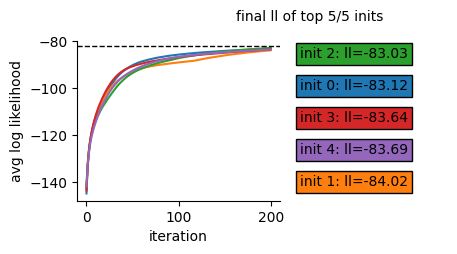

In [109]:
top_n_inits = 5

n_inits, n_steps = all_lls.shape

fmt = ".2f"
# -----------------------------
fig = plt.figure(figsize=(3,2))
fig.subplots_adjust(top=0.9, bottom=0.1, right=0.8)  # Leave space on the right hand side

ax = plt.gca()
ax.plot(all_lls.T)
ax.set_xlabel('iteration')
ax.set_ylabel('avg log likelihood')

# Annotate top runs with final ll

sorted_idxs = jnp.argsort(all_lls[:,-1])[:top_n_inits]
ypos = onp.linspace(0.2, 1, endpoint=False, num=top_n_inits)
ypos += (ypos[1] - ypos[0])

for i_init, y in zip(sorted_idxs, ypos):
    c = f"C{i_init}"

    ax.annotate(
        f"init {i_init}: ll={all_lls[i_init,-1]:{fmt}}",
        xy=(1.0, y), xycoords='figure fraction',
        arrowprops={'arrowstyle' : '-', 'ec': c, 'lw': 1},
        bbox={'boxstyle': "Square, pad=0.3", 'fc': c},
        ha='left', va='center',
        backgroundcolor=c,
    )

ax.text(0.9, 1, f"final ll of top {top_n_inits}/{n_inits} inits", transform=fig.transFigure, ha='center')
sns.despine()

# reference model
ref_ll = multinomial_ll(data, *true_params).mean()
ax.axhline(ref_ll, lw=1, ls='--', color='k')

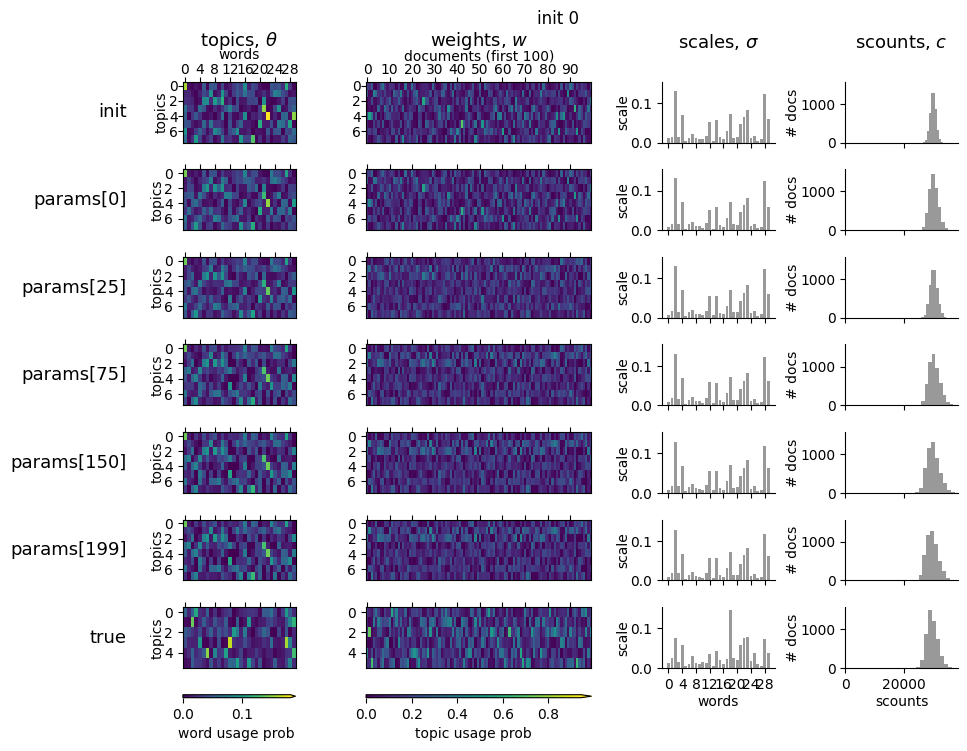

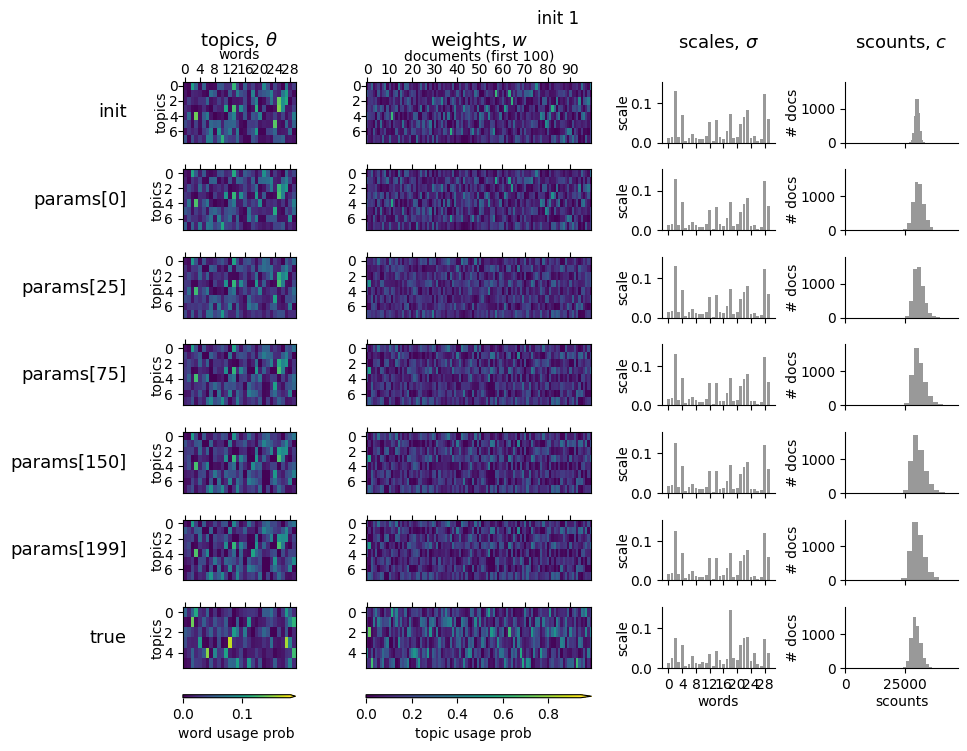

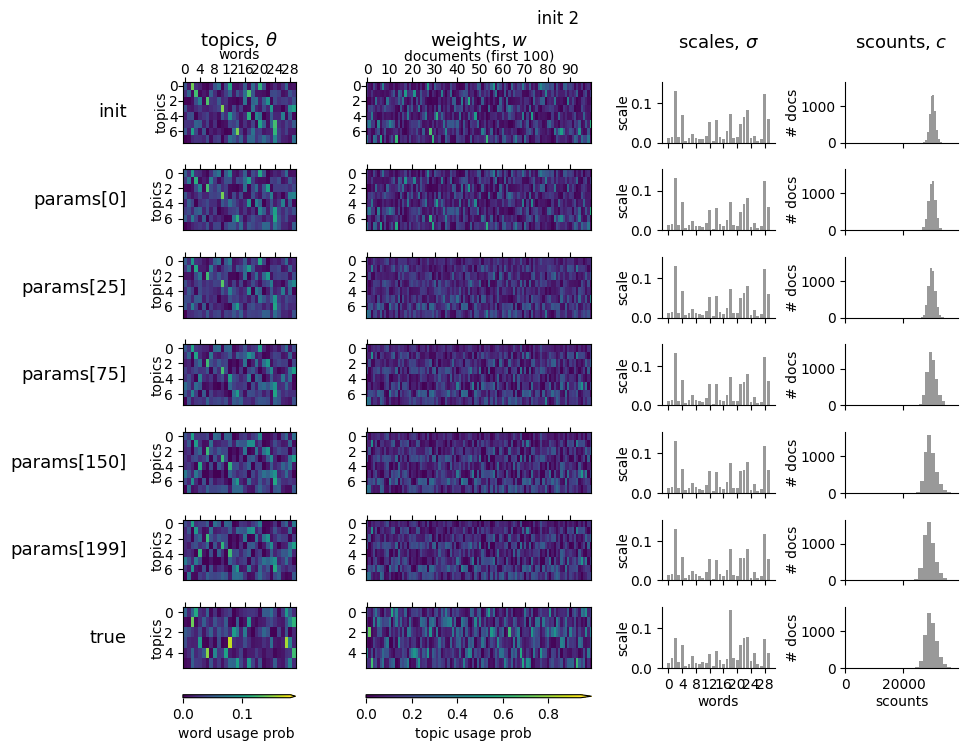

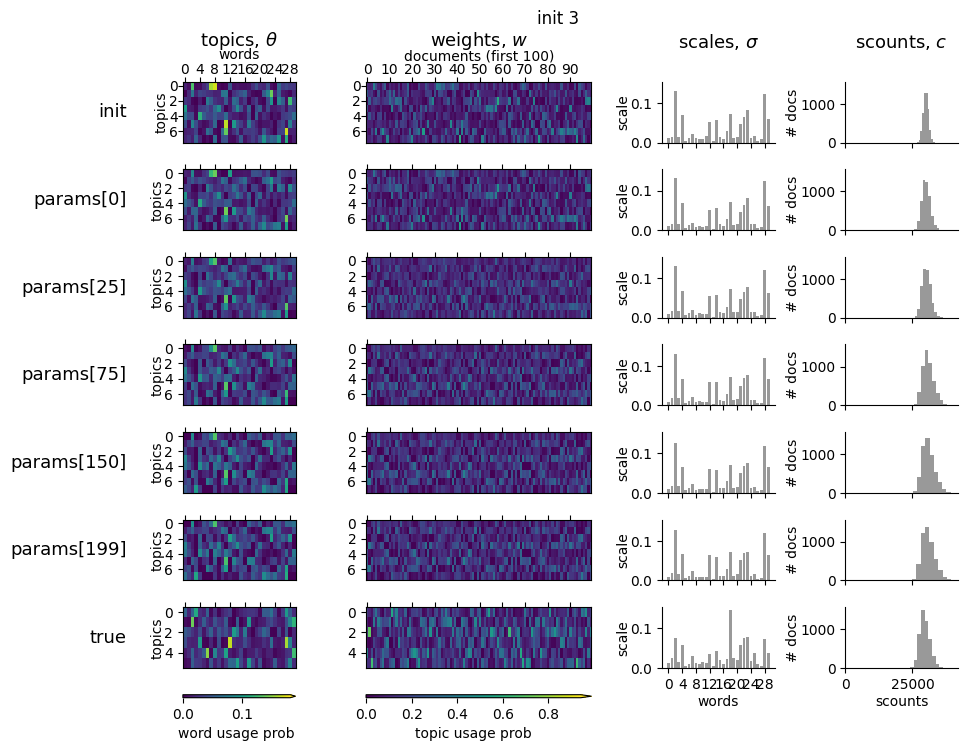

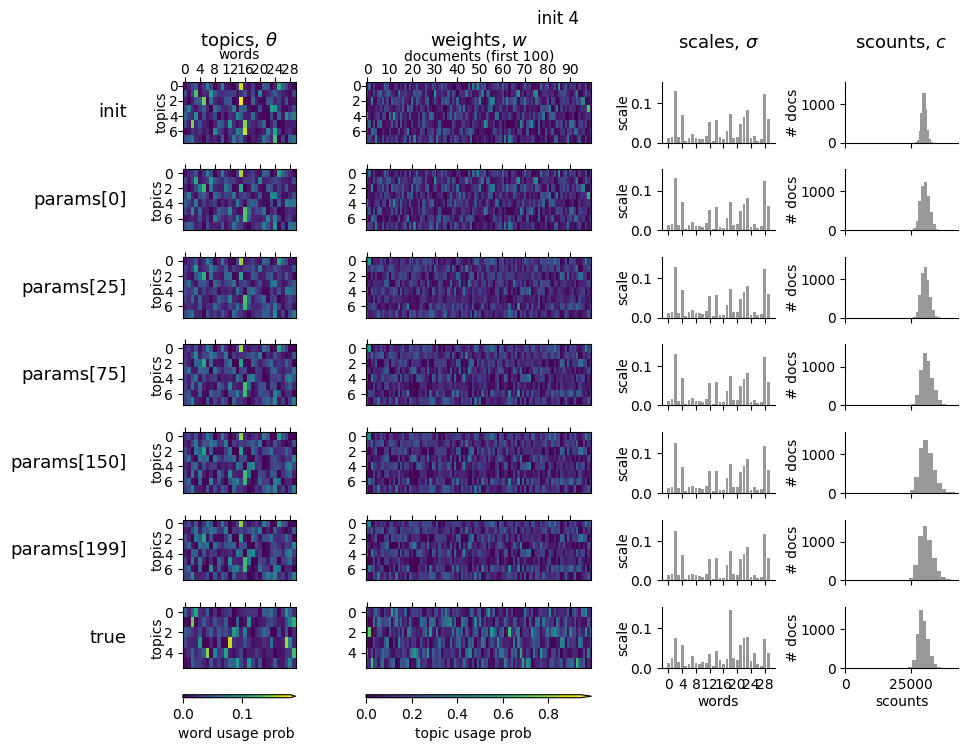

In [92]:
steps = onp.array([0, 25, 75, 150, 199])

n_inits, n_steps = all_topics.shape[:2]


topic_vmax = 1.1 * true_params.topics.max()
weight_vmax = 1.1 * true_params.weights.max()

for i_init in range(n_inits):
    init_params = Params(*[params[i_init] for params in batched_init_params])
    params_by_iter = {
        f"params[{i_step}]": Params(
            all_topics[i_init, i_step],
            all_weights[i_init, i_step],
            all_scales[i_init, i_step],
            all_scounts[i_init, i_step],
        ) for i_step in steps
    }

    tmp = {"init": init_params, **params_by_iter, "true": true_params,}
    fig = compare_params(tmp, topic_vmax=topic_vmax, weight_vmax=weight_vmax)
    
    fig.suptitle(f"init {i_init}", y=0.97)


First, assume that we are **given** the true topics. Are the true topics are a subset of the fitted params.

In [86]:
n_inits = len(all_topics)
all_final_params = [
    Params(
        all_topics[i_init, -1],
        all_weights[i_init, -1],
        all_scales[i_init, -1],
        all_scounts[i_init, -1],
    ) for i_init in range(n_inits)
]

In [102]:
nxent = lambda p, q: (-p * onp.log(q)).sum()

perms, permd_params, perm_costs = [], [], []
for (topics, weights, scales, scounts) in all_final_params:
    
    # cost_matrix: shape (n_true_topics, n_fitted_topics)
    cost_matrix = cdist(true_params.topics, topics, 'cosine') 
    _, i_perm = linear_sum_assignment(cost_matrix)

    permd_topics = topics[i_perm,]
    permd_weights = weights[:,i_perm]
    permd_weights /= permd_weights.sum(axis=-1, keepdims=True)
    
    perms.append(i_perm)
    permd_params.append(Params(permd_topics, permd_weights, scales, scounts))
    perm_costs.append(onp.diag(cost_matrix[:, i_perm]).sum())

Text(0.5, 1.0, 'min cosine dist perm, given true topics')

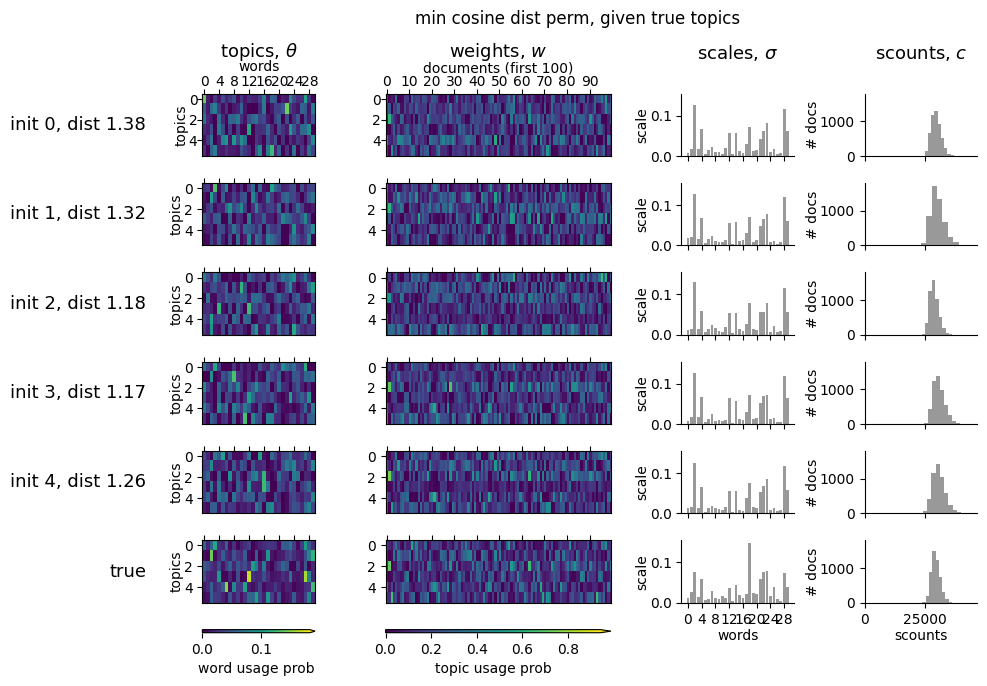

In [112]:
n_inits = len(all_topics)

topic_vmax = 1.1 * true_params.topics.max()
weight_vmax = 1.1 * true_params.weights.max()

tmp = {
    **{f'init {i_init}, dist {perm_costs[i_init]:.2f}': permd_params[i_init]
        for i_init in range(n_inits)
    },
    'true': true_params
}
fig = compare_params(tmp, topic_vmax=topic_vmax, weight_vmax=weight_vmax)

fig.suptitle(f'min cosine dist perm, given true topics', y=1.0)